In [2]:
# Se instalan las librerías
!pip install h2o
!pip install pmdarima
!pip install statsmodels
!pip install pandas_market_calendars
!pip install darts
!pip install ucimlrepo
!pip install dask[dataframe]
!pip install polars pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.3/265.3 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.4-py2.py3-none-any.whl size=265375576 sha256=a97168db332e4fe99d859952e887c662d9843307b12bec8c9a14450c8e547ba0
  Stored in directory: /root/.cache/pip/wheels/4d/a6/47/8bfeb1026fd65cb8630beb74d8e3bec844f572cf4f336fdd56
Successfully built h2o
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.1/196.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 872.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-no

In [3]:
# Se cargan las librerías
from pandas import DataFrame
from pandas import concat
import random
from scipy import stats
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML
import gc
import statsmodels.api as sm
from darts.models import (NaiveSeasonal,NaiveDrift,RNNModel,Prophet,ExponentialSmoothing,ARIMA,AutoARIMA,TCNModel,TransformerModel,Theta,FFT)
%matplotlib inline

##**1. Preparación de los datos**


In [4]:
#Descarga de datasets de la colección UCI Machine Learning Repository

from ucimlrepo import fetch_ucirepo
import pandas as pd

air_quality = fetch_ucirepo(id=360)

#Datos (as pandas dataframes)
Xair = air_quality.data.features
yair = air_quality.data.targets

#Informacion de la variables
print(air_quality.variables)

             name     role         type demographic  \
0            Date  Feature         Date        None   
1            Time  Feature  Categorical        None   
2          CO(GT)  Feature      Integer        None   
3     PT08.S1(CO)  Feature  Categorical        None   
4        NMHC(GT)  Feature      Integer        None   
5        C6H6(GT)  Feature   Continuous        None   
6   PT08.S2(NMHC)  Feature  Categorical        None   
7         NOx(GT)  Feature      Integer        None   
8    PT08.S3(NOx)  Feature  Categorical        None   
9         NO2(GT)  Feature      Integer        None   
10   PT08.S4(NO2)  Feature  Categorical        None   
11    PT08.S5(O3)  Feature  Categorical        None   
12              T  Feature   Continuous        None   
13             RH  Feature   Continuous        None   
14             AH  Feature   Continuous        None   

                                          description       units  \
0                                                N

In [5]:
# Crear el DataFrame con todas las características
df_total= air_quality.data.features

#Seleccionar las columnas específicas con las que se va a trabajar
df = df_total[['Date', 'Time', 'C6H6(GT)', 'T', 'RH']]


In [6]:
# Cambiar el nombre de la variable C6H6(GT)
df = df.rename(columns={'C6H6(GT)': 'C6H6'})


In [7]:
# Crear columna Datetime combinada
df['Datetime'] = df['Date'] + ' ' + df['Time']

# Intentar convertir a datetime y capturar el error
# En lugar de poner format='%d/%m/%Y %H:%M:%S' poner dayfirst=False para que infiera automaticamente el formato
try:
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=False)
except ValueError as e:
    print(f"Error al convertir fechas: {e}")

# Mostrars las filas que no se convirtieron correctamente
print(df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()])

# Mostrar las filas que no se convirtieron correctamente para asegurarnos que se convirtió buen
invalid_dates = df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()]
print("Filas con fechas no válidas:")
print(invalid_dates)

Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []
Filas con fechas no válidas:
Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []


In [8]:
# Establecer la columna datetime como índice, eliminar las columnas Date y Time
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [9]:
# Reemplazar los valores -200 en la columna T con NaN
df['C6H6'] = df['C6H6'].replace(-200, pd.NA)
df['T'] = df['T'].replace(-200, pd.NA)
df['RH'] = df['RH'].replace(-200, pd.NA)

# Aplicar forward fill para reemplazar los valores NaN
df['C6H6'].ffill(inplace=True)
df['T'].ffill(inplace=True)
df['RH'].ffill(inplace=True)


In [12]:
#Sólo la columna C6H6
df = df[['C6H6']]
print(df)

                     C6H6
Datetime                 
2004-03-10 18:00:00  11.9
2004-03-10 19:00:00   9.4
2004-03-10 20:00:00   9.0
2004-03-10 21:00:00   9.2
2004-03-10 22:00:00   6.5
...                   ...
2005-04-04 10:00:00  13.5
2005-04-04 11:00:00  11.4
2005-04-04 12:00:00  12.4
2005-04-04 13:00:00   9.5
2005-04-04 14:00:00  11.9

[9357 rows x 1 columns]


##**2. Modelado de la serie df**

Es necesario hacer el modelado de la serie para convertirla en un conjunto de datos de aprendizaje supervisado y así poder usar H2O.

In [13]:
#Se aplica la función time_series_to_supervised para crear el conjunto de datos supervisado.
#Se utilizar lags pasados=24 hs, lags futuros=24 (para que capte la estacionalidad diaria que se ve en la gráfica de la serie)

def time_series_to_supervised(df, n_lag=24, n_fut=24, selLag=None, selFut=None, dropnan=True):
    n_vars = 1 if type(df) is list else df.shape[1]
    df = DataFrame(df)
    origNames = df.columns
    cols, names = list(), list()

    # incluir todos los atributos del período actual
    cols.append(df.shift(0))
    names += [('%s' % origNames[j]) for j in range(n_vars)]

    # retrasar cualquier atributo del período anterior (t-n_lag,...,t-1)
    n_lag = max(0, n_lag)  # forzar un número válido de períodos de retraso
    for i in range(n_lag, 0, -1):
        suffix = '(t-%d)' % i
        if selLag is None:
            cols.append(df.shift(i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:
            for var in selLag:
                cols.append(df[var].shift(i))
                names += [('%s%s' % (var, suffix))]

    # incluir atributos de período futuro (t+1,...,t+n_fut)
    n_fut = max(n_fut, 0)  # forzar un número válido de períodos futuros para retroceder
    for i in range(1, n_fut + 1):
        suffix = '(t+%d)' % i
        if selFut is None:
            cols.append(df.shift(-i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:  # copiar solo atributos futuros seleccionados
            for var in selFut:
                cols.append(df[var].shift(-i))
                names += [('%s%s' % (var, suffix))]

    # combinar todo
    agg = concat(cols, axis=1)
    agg.columns = names

    # borra filas con valores NaN introducidos por el lagging
    if dropnan:
        agg.dropna(inplace=True)

    return agg


Esta funcion convierte una serie temporal en un conjunto de datos de aprendizaje supervisado agregando 24 períodos anteriores y futuros diferido en el tiempo.

    Parametros;
    param data: una serie de atributos periódicos como una lista o NumPy array
    param n_lag: número de períodos ANTERIORES que se retrasarán como entrada (X); genera: Xa(t-1), Xa(t-2); min= 0 --> nada retrasado
    param n_fut: número de períodos FUTUROS para agregar como producción objetivo (y); genera You(t+1); min= 0 --> sin períodos futuros
    param selLag:  copia únicamente estos atributos específicos del período ANTERIOR; predeterminado = Ninguno; EJ: ['Xa', 'Xb']
    param selFut: copia únicamente estos atributos específicos del período FUTURO; predeterminado = Ninguno; EJ: ['rslt', 'xx']
    param dropnan: True= borra filas con valoresNaN ; default= True
    return: un Pandas DataFrame de datos de series temporales organizados para el aprendizaje supervisado
    NOTAS:
    (1) Los datos del período actual siempre se incluyen en la salida.
    (2) Se agrega un sufijo a los nombres de las columnas originales para indicar una referencia de tiempo relativa: por ejemplo, (t) es la corriente
    período; (t-2) es de dos períodos del pasado; (t+1) es del siguiente periodo
    (3) Esta es una extensión de la función series_to_supervised() de Jason Brownlee, personalizada para uso de IMF.

In [14]:
# Obtener el dataFrame procesado con los lags (entradas) y lags de (salidas) en un formato que se puede utilizar para entrenamiento de modelos de aprendizaje supervisado.
df_processed = time_series_to_supervised(df, n_lag=24, n_fut=24, selLag=None, selFut=['C6H6'], dropnan=True)
print(df_processed.head())


                     C6H6  C6H6(t-24)  C6H6(t-23)  C6H6(t-22)  C6H6(t-21)  \
Datetime                                                                    
2004-03-11 18:00:00  20.8        11.9         9.4         9.0         9.2   
2004-03-11 19:00:00  27.4         9.4         9.0         9.2         6.5   
2004-03-11 20:00:00  24.0         9.0         9.2         6.5         4.7   
2004-03-11 21:00:00  12.8         9.2         6.5         4.7         3.6   
2004-03-11 22:00:00   4.7         6.5         4.7         3.6         3.3   

                     C6H6(t-20)  C6H6(t-19)  C6H6(t-18)  C6H6(t-17)  \
Datetime                                                              
2004-03-11 18:00:00         6.5         4.7         3.6         3.3   
2004-03-11 19:00:00         4.7         3.6         3.3         2.3   
2004-03-11 20:00:00         3.6         3.3         2.3         1.7   
2004-03-11 21:00:00         3.3         2.3         1.7         1.3   
2004-03-11 22:00:00         2.3   

In [15]:
# Separación en entrenamiento (80%) y testeo (20%)
df_processed.reset_index(drop=True,inplace=True) # reseteo el índice
df_train = df_processed.loc[:int(df_processed.shape[0]*0.8),:]
df_test = df_processed.loc[int(df_processed.shape[0]*0.8):,:]

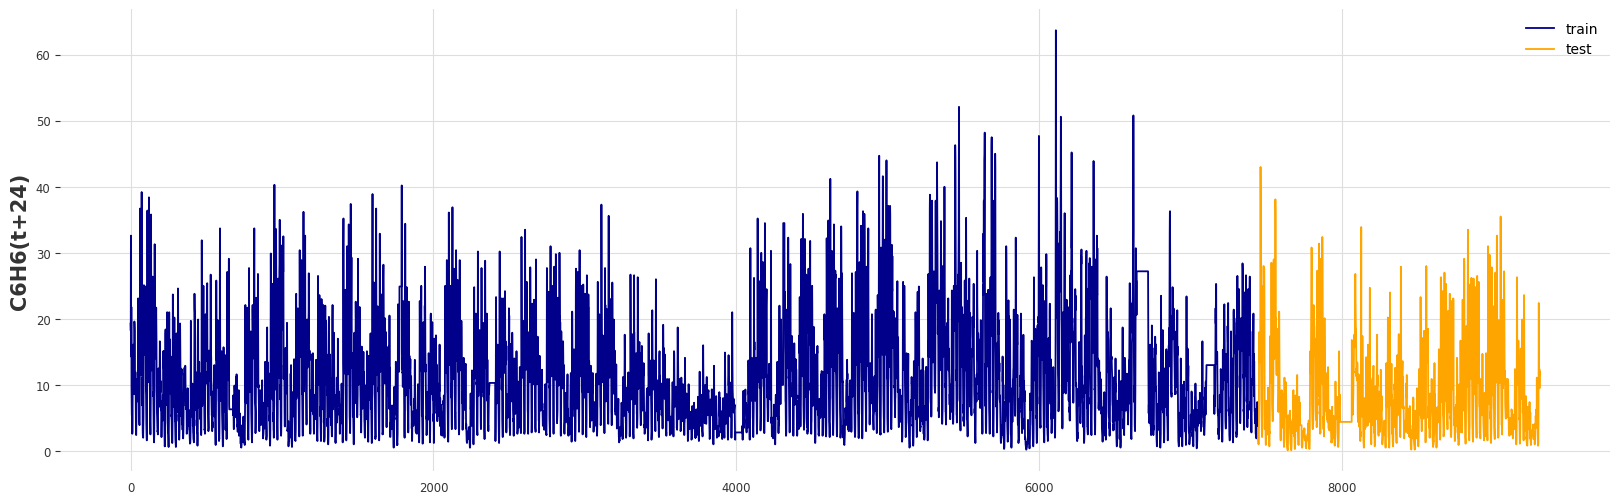

In [19]:
# Gráficas de las bases de entrenamiento y testeo juntas
plt.figure(figsize=(20, 6))
plt.plot(df_train.index,df_train['C6H6(t+24)'],color='darkblue')
plt.plot(df_test.index,df_test['C6H6(t+24)'],color='orange')
plt.ylabel('C6H6(t+24)',fontsize=15)
plt.legend(['train','test'])
plt.show()

##**3. Inicio de H2OAutoML**

In [20]:
# Inicialización de sesión
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.23" 2024-04-16; OpenJDK Runtime Environment (build 11.0.23+9-post-Ubuntu-1ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 11.0.23+9-post-Ubuntu-1ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp7l2968q7
  JVM stdout: /tmp/tmp7l2968q7/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp7l2968q7/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         04 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.4
H2O_cluster_version_age:    21 days and 49 minutes
H2O_cluster_name:           H2O_from_python_unknownUser_q41m6e
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.170 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

In [21]:
# Se convierten los dataframe de pandas en h2o frames
df_train = h2o.H2OFrame(df_train)
df_test = h2o.H2OFrame(df_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [22]:
#Verificación del tipo de datos
df_train.types

{'C6H6': 'real',
 'C6H6(t-24)': 'real',
 'C6H6(t-23)': 'real',
 'C6H6(t-22)': 'real',
 'C6H6(t-21)': 'real',
 'C6H6(t-20)': 'real',
 'C6H6(t-19)': 'real',
 'C6H6(t-18)': 'real',
 'C6H6(t-17)': 'real',
 'C6H6(t-16)': 'real',
 'C6H6(t-15)': 'real',
 'C6H6(t-14)': 'real',
 'C6H6(t-13)': 'real',
 'C6H6(t-12)': 'real',
 'C6H6(t-11)': 'real',
 'C6H6(t-10)': 'real',
 'C6H6(t-9)': 'real',
 'C6H6(t-8)': 'real',
 'C6H6(t-7)': 'real',
 'C6H6(t-6)': 'real',
 'C6H6(t-5)': 'real',
 'C6H6(t-4)': 'real',
 'C6H6(t-3)': 'real',
 'C6H6(t-2)': 'real',
 'C6H6(t-1)': 'real',
 'C6H6(t+1)': 'real',
 'C6H6(t+2)': 'real',
 'C6H6(t+3)': 'real',
 'C6H6(t+4)': 'real',
 'C6H6(t+5)': 'real',
 'C6H6(t+6)': 'real',
 'C6H6(t+7)': 'real',
 'C6H6(t+8)': 'real',
 'C6H6(t+9)': 'real',
 'C6H6(t+10)': 'real',
 'C6H6(t+11)': 'real',
 'C6H6(t+12)': 'real',
 'C6H6(t+13)': 'real',
 'C6H6(t+14)': 'real',
 'C6H6(t+15)': 'real',
 'C6H6(t+16)': 'real',
 'C6H6(t+17)': 'real',
 'C6H6(t+18)': 'real',
 'C6H6(t+19)': 'real',
 'C6H6(t+20)

In [23]:
#Verificacion del tamaño de los datafram
print(df_train.shape)
print(df_test.shape)


(7448, 49)
(1862, 49)


In [24]:
# Se define el target (variable a predecir) y la base de entrenamiento
y = 'C6H6(t+24)'
X = df_train.columns
X.remove(y)

**3. a) Modelo 1: aml1**

In [25]:
# Configuración de los parámetros de entrenamiento: cantidad de modelos, tiempo máxmo de ejecución, tipo de informe, seed la semilla
aml1 = H2OAutoML(max_models=10, max_runtime_secs = 360,seed = 42, verbosity="info", exclude_algos=['StackedEnsemble']) # Se excluyeron los algoritmos StackedEnsemble, se podria excluir cualquier otro

In [26]:
# Inicio del entrenamiento
aml1.train(x = X,
          y = y,
          training_frame = df_train,
          leaderboard_frame = df_test)

AutoML progress: |
21:06:07.922: Project: AutoML_1_20240730_210607
21:06:07.924: 5-fold cross-validation will be used.
21:06:07.925: Setting stopping tolerance adaptively based on the training frame: 0.011587244366483038
21:06:07.925: Build control seed: 42
21:06:07.926: training frame: Frame key: AutoML_1_20240730_210607_training_Key_Frame__upload_a99a3e0003ba29055ccbb7ee86d84d2a.hex    cols: 49    rows: 7448  chunks: 1    size: 734020  checksum: -6819537654276400954
21:06:07.927: validation frame: NULL
21:06:07.927: leaderboard frame: Frame key: Key_Frame__upload_a62738698cf145f9a8e8123a9fd24ab0.hex    cols: 49    rows: 1862  chunks: 1    size: 186592  checksum: 6195408535135331826
21:06:07.927: blending frame: NULL
21:06:07.928: response column: C6H6(t+24)
21:06:07.928: fold column: null
21:06:07.928: weights column: null
21:06:07.957: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_3_AutoML_1_20240730_210607


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    58                 58                          73220                  8            8            8             15            164           95.8103

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 2.9280194179964814
RMSE: 1.7111456448813704
MAE: 1.2108459876356077
RMSLE: 0.16114086608044237
Mean Residual Deviance: 2.9280194179964814

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 9.303680091728621
RMSE: 3.050193451525431
MAE: 2.0080386761832525
RMSLE: 0.23746122400826924
Mean Residual Deviance: 9.303680091728621

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
aic                     nan       0           nan           nan           nan           nan           nan
loglikelihood           nan       0           nan           nan           nan           nan           nan
mae                     2.00762   0.058537    2.00071       2.05856       2.07535       1.94097       1.96253
mean_residual_deviance  9.306     0.958788    9.01947       9.90096       10.6592       8.35447       8.59584
mse                     9.306     0.958788    9.01947       9.90096       10.6592       8.35447       8.59584
r2                      0.843603  0.0115996   0.845774      0.83696       0.827189      0.854994      0.853101
residual_deviance       9.306     0.958788    9.01947       9.90096       10.6592       8.35447       8.59584
rmse                    3.04739   0.155776    3.00324       3.14658       3.26485       2.89041       2.93187
rmsle                   0.237235  0.00643355  0.238786      0.242907      0.243047      0.22824       0.233198

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2024-07-30 21:10:49  13.920 sec  0                  7.70748          5.99567         59.4053
    2024-07-30 21:10:49  14.172 sec  5                  5.19609          3.99179         26.9993
    2024-07-30 21:10:49  14.378 sec  10                 3.68174          2.78497         13.5552
    2024-07-30 21:10:49  14.587 sec  15                 2.87044          2.12719         8.2394
    2024-07-30 21:10:49  14.800 sec  20                 2.43062          1.76559         5.90791
    2024-07-30 21:10:50  15.006 sec  25                 2.20796          1.57779         4.87508
    2024-07-30 21:10:50  15.202 sec  30                 2.05883          1.46001         4.2388
    2024-07-30 21:10:50  15.390 sec  35                 1.95093          1.37646         3.80614
    2024-07-30 21:10:50  15.577 sec  40                 1.88114          1.32631         3.53867
    2024-07-30 21:10:50  15.750 sec  45                 1.82867          1.28785         3.34403
    2024-07-30 21:10:51  15.949 sec  50                 1.76308          1.24524         3.10846
    2024-07-30 21:10:51  16.119 sec  55                 1.72444          1.21981         2.97371
    2024-07-30 21:10:51  16.217 sec  58                 1.71115          1.21085         2.92802

Variable Importances: 
variable    relative_importance    scaled_importance      percentage
----------  ---------------------  ---------------------  ---------------------
C6H6(t+23)  958145.3125            1.0                    0.473308

In [27]:
# leaderboard: es un comando especifico de H2O que muestra en una tabla los modelos que han sido entrenados
lb1 = aml1.leaderboard
lb1

model_id                               rmse      mse      mae       rmsle    mean_residual_deviance
----------------------------------  -------  -------  -------  ----------  ------------------------
GBM_3_AutoML_1_20240730_210607      2.73633  7.4875   1.74723    0.278398                   7.4875
GBM_4_AutoML_1_20240730_210607      2.74013  7.50829  1.75185    0.284934                   7.50829
GBM_2_AutoML_1_20240730_210607      2.7511   7.56858  1.74132    0.284078                   7.56858
GBM_1_AutoML_1_20240730_210607      2.76954  7.67036  1.78512    0.28993                    7.67036
DRF_1_AutoML_1_20240730_210607      2.82494  7.98031  1.85448    0.310876                   7.98031
XGBoost_3_AutoML_1_20240730_210607  2.8596   8.1773   1.85461    0.303969                   8.1773
GLM_1_AutoML_1_20240730_210607      2.96096  8.76729  1.92813  nan                          8.76729
XGBoost_2_AutoML_1_20240730_210607  2.99739  8.98437  1.94081    0.312891                   8.98437
XGBoost_1_AutoML_1_20240730_210607  3.01268  9.07622  2.01048    0.321912                   9.07622
[9 rows x 6 columns]

**3. b) Modelo 2: aml2**

Se prueba un segundo modelo aml2, con más tiempo de ejecucion y sin excluir Stacked Ensemble que es un método que combina múltiples modelos.

In [ ]:
# Configuración de un segundo modelo con más tiempo e incluyendo todo tipo de algoritmos
aml2 = H2OAutoML(max_models=10, max_runtime_secs = 1800,seed = 42, verbosity="info")

In [ ]:
# Inicio del entrenamiento
aml2.train(x = X,
          y = y,
          training_frame = df_train,
          leaderboard_frame = df_test)

AutoML progress: |
23:44:18.163: Project: AutoML_2_20240729_234418
23:44:18.163: 5-fold cross-validation will be used.
23:44:18.167: Setting stopping tolerance adaptively based on the training frame: 0.011587244366483038
23:44:18.167: Build control seed: 42
23:44:18.168: training frame: Frame key: AutoML_2_20240729_234418_training_Key_Frame__upload_a973013428bd27618f6b280f48d24545.hex    cols: 49    rows: 7448  chunks: 1    size: 734020  checksum: -6819537654276400954
23:44:18.168: validation frame: NULL
23:44:18.168: leaderboard frame: Frame key: Key_Frame__upload_b8fe913d6b83e788abba986445e64b4d.hex    cols: 49    rows: 1862  chunks: 1    size: 186592  checksum: 6195408535135331826
23:44:18.168: blending frame: NULL
23:44:18.168: response column: C6H6(t+1)
23:44:18.168: fold column: null
23:44:18.168: weights column: null
23:44:18.169: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 1

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_2_20240729_234418


Model Summary for Stacked Ensemble: 
key                                   value
------------------------------------  ----------------
Stacking strategy                     cross_validation
Number of base models (used / total)  8/10
# GBM base models (used / total)      4/4
# XGBoost base models (used / total)  2/3
# DRF base models (used / total)      1/2
# GLM base models (used / total)      1/1
Metalearner algorithm                 GLM
Metalearner fold assignment scheme    Random
Metalearner nfolds                    5
Metalearner fold_column
Custom metalearner hyperparameters    None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 2.7868358126324604
RMSE: 1.6693818654317711
MAE: 1.1149629569443302
RMSLE: 0.13277736614887403
Mean Residual Deviance: 2.7868358126324604
R^2: 0.9531064278418229
Null degrees of freedom: 7447
Residual degrees of freedom: 7439
Null deviance: 442626.82873620273
Residual deviance: 20756.353132486565
AIC: 28790.014496948403

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 5.220208878874755
RMSE: 2.2847776432017963
MAE: 1.4737216813540952
RMSLE: 0.16955232691104472
Mean Residual Deviance: 5.220208878874755
R^2: 0.9121605081172544
Null degrees of freedom: 7447
Residual degrees of freedom: 7440
Null deviance: 442869.4068361817
Residual deviance: 38880.11572985917
AIC: 33462.607066504715

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
aic                     6707.17   262.573     6764.56       6891.76       6790.98       6842.87       6245.68
loglikelihood           0         0           0             0             0             0             0
mae                     1.47336   0.0505277   1.40161       1.49015       1.5063        1.52593       1.44281
mean_residual_deviance  5.22603   0.38491     4.56104       5.29564       5.34657       5.55913       5.36776
mse                     5.22603   0.38491     4.56104       5.29564       5.34657       5.55913       5.36776
null_deviance           88573.9   8312.29     92073.9       92515.3       94115.9       90254.9       73909.3
r2                      0.911542  0.00880909  0.923241      0.91267       0.914694      0.907713      0.89939
residual_deviance       7774.88   525.448     7065.06       8075.85       8014.51       8327.57       7391.4
rmse                    2.28475   0.0860518   2.13566       2.30123       2.31227       2.35778       2.31684
rmsle                   0.169499  0.00352845  0.166616      0.166537      0.168931      0.175137      0.170273

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [ ]:
# Listado de los modelos ganadores
lb2= aml2.leaderboard
lb2

model_id                                                    rmse      mse      mae     rmsle    mean_residual_deviance
-------------------------------------------------------  -------  -------  -------  --------  ------------------------
StackedEnsemble_AllModels_1_AutoML_2_20240729_234418     1.93141  3.73035  1.17089  0.181066                   3.73035
GBM_1_AutoML_2_20240729_234418                           1.93464  3.74282  1.17795  0.188412                   3.74282
StackedEnsemble_BestOfFamily_1_AutoML_2_20240729_234418  1.94058  3.76586  1.1799   0.182557                   3.76586
GBM_3_AutoML_2_20240729_234418                           1.9624   3.85101  1.19548  0.186631                   3.85101
GBM_2_AutoML_2_20240729_234418                           1.96706  3.86933  1.19123  0.18593                    3.86933
DRF_1_AutoML_2_20240729_234418                           2.00129  4.00516  1.22759  0.191421                   4.00516
GBM_4_AutoML_2_20240729_234418                           2.01241  4.04978  1.21364  0.188442                   4.04978
XRT_1_AutoML_2_20240729_234418                           2.03774  4.15237  1.24952  0.193741                   4.15237
XGBoost_3_AutoML_2_20240729_234418                       2.07973  4.32527  1.2683   0.199843                   4.32527
GLM_1_AutoML_2_20240729_234418                           2.10303  4.42272  1.29798  0.20676                    4.42272
XGBoost_1_AutoML_2_20240729_234418                       2.15074  4.6257   1.34094  0.207592                   4.6257
XGBoost_2_AutoML_2_20240729_234418                       2.1598   4.66475  1.34147  0.211058                   4.66475
[12 rows x 6 columns]

Los modelos resultantes no han superado las métricas de los modelos seleccionados por lb1, por lo que se seguiría analizando estos modelos.

**3. c) Elección del mejor modelo y medidas de precisión**

In [28]:
# Elección del mejor modelo
mejor_modelo= aml1.leader

In [29]:
# Predicciones en el df_test
df_test_predict = mejor_modelo.predict(df_test)
print(df_test_predict)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
  predict
 3.44989
 3.20277
 2.42646
 1.13625
 0.975924
 1.26469
 2.07363
 6.95865
19.4648
11.021
[1862 rows x 1 column]



In [32]:
# Convertir el H2OFrame de df_test a DataFrame de pandas
df_test_pandas = df_test.as_data_frame(use_multi_thread=True) #el argumento es para que sea más rápido
df_test_pandas.head()

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


C6H6  C6H6(t-24)  C6H6(t-23)  C6H6(t-22)  C6H6(t-21)  C6H6(t-20)  \
0   9.8         7.5         6.2         5.1         4.8         3.1   
1   7.6         6.2         5.1         4.8         3.1         2.8   
2   6.0         5.1         4.8         3.1         2.8         4.3   
3   5.9         4.8         3.1         2.8         4.3         9.7   
4   4.2         3.1         2.8         4.3         9.7        10.9   

   C6H6(t-19)  C6H6(t-18)  C6H6(t-17)  C6H6(t-16)  ...  C6H6(t+15)  \
0         2.8         4.3         9.7        10.9  ...         2.8   
1         4.3         9.7        10.9        10.6  ...         3.3   
2         9.7        10.9        10.6        10.0  ...         3.4   
3        10.9        10.6        10.0        11.6  ...         7.1   
4        10.6        10.0        11.6        15.6  ...         7.4   

   C6H6(t+16)  C6H6(t+17)  C6H6(t+18)  C6H6(t+19)  C6H6(t+20)  C6H6(t+21)  \
0         3.3         3.4         7.1         7.4         4.3         3.9   
1         3.4         7.1         7.4         4.3         3.9         5.2   
2         7.1         7.4         4.3         3.9         5.2         3.8   
3         7.4         4.3         3.9         5.2         3.8         3.5   
4         4.3         3.9         5.2         3.8         3.5         2.9   

   C6H6(t+22)  C6H6(t+23)  C6H6(t+24)  
0         5.2         3.8         3.5  
1         3.8         3.5         2.9  
2         3.5         2.9         1.4  
3         2.9         1.4         1.1  
4         1.4         1.1         1.0  

[5 rows x 49 columns]

In [38]:
#Predicción vs Valores Reales
df_results = pd.DataFrame()
df_results['valores reales'] = df_test_pandas['C6H6(t+24)'].reset_index(drop=True) # valores reales
df_results['predicciones'] = h2o.as_list(df_test_predict, use_pandas=True) # predicciones
df_results.head()

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


valores reales  predicciones
0             3.5      3.449894
1             2.9      3.202770
2             1.4      2.426459
3             1.1      1.136246
4             1.0      0.975924

In [39]:
# Medidas de precisión en el df_tes
performance = aml1.leader.model_performance(df_test) #al mejor modelo según entrenamiento GBM le calcula la performance en el df_test
performance

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 7.487503349963837
RMSE: 2.7363302706295958
MAE: 1.7472346112801627
RMSLE: 0.2783978063584175
Mean Residual Deviance: 7.487503349963837

In [42]:
# Listado de todos los modelos entrenados
model_ids = list(aml1.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_ids

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


['GBM_3_AutoML_1_20240730_210607',
 'GBM_4_AutoML_1_20240730_210607',
 'GBM_2_AutoML_1_20240730_210607',
 'GBM_1_AutoML_1_20240730_210607',
 'DRF_1_AutoML_1_20240730_210607',
 'XGBoost_3_AutoML_1_20240730_210607',
 'GLM_1_AutoML_1_20240730_210607',
 'XGBoost_2_AutoML_1_20240730_210607',
 'XGBoost_1_AutoML_1_20240730_210607']

In [43]:
# Obtener los detalles del modelo específico identificado como GBM_3...
h2o.get_model([mid for mid in model_ids if "GBM_3" in mid][0])

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_3_AutoML_1_20240730_210607


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    58                 58                          73220                  8            8            8             15            164           95.8103

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 2.9280194179964814
RMSE: 1.7111456448813704
MAE: 1.2108459876356077
RMSLE: 0.16114086608044237
Mean Residual Deviance: 2.9280194179964814

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 9.303680091728621
RMSE: 3.050193451525431
MAE: 2.0080386761832525
RMSLE: 0.23746122400826924
Mean Residual Deviance: 9.303680091728621

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
aic                     nan       0           nan           nan           nan           nan           nan
loglikelihood           nan       0           nan           nan           nan           nan           nan
mae                     2.00762   0.058537    2.00071       2.05856       2.07535       1.94097       1.96253
mean_residual_deviance  9.306     0.958788    9.01947       9.90096       10.6592       8.35447       8.59584
mse                     9.306     0.958788    9.01947       9.90096       10.6592       8.35447       8.59584
r2                      0.843603  0.0115996   0.845774      0.83696       0.827189      0.854994      0.853101
residual_deviance       9.306     0.958788    9.01947       9.90096       10.6592       8.35447       8.59584
rmse                    3.04739   0.155776    3.00324       3.14658       3.26485       2.89041       2.93187
rmsle                   0.237235  0.00643355  0.238786      0.242907      0.243047      0.22824       0.233198

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2024-07-30 21:10:49  13.920 sec  0                  7.70748          5.99567         59.4053
    2024-07-30 21:10:49  14.172 sec  5                  5.19609          3.99179         26.9993
    2024-07-30 21:10:49  14.378 sec  10                 3.68174          2.78497         13.5552
    2024-07-30 21:10:49  14.587 sec  15                 2.87044          2.12719         8.2394
    2024-07-30 21:10:49  14.800 sec  20                 2.43062          1.76559         5.90791
    2024-07-30 21:10:50  15.006 sec  25                 2.20796          1.57779         4.87508
    2024-07-30 21:10:50  15.202 sec  30                 2.05883          1.46001         4.2388
    2024-07-30 21:10:50  15.390 sec  35                 1.95093          1.37646         3.80614
    2024-07-30 21:10:50  15.577 sec  40                 1.88114          1.32631         3.53867
    2024-07-30 21:10:50  15.750 sec  45                 1.82867          1.28785         3.34403
    2024-07-30 21:10:51  15.949 sec  50                 1.76308          1.24524         3.10846
    2024-07-30 21:10:51  16.119 sec  55                 1.72444          1.21981         2.97371
    2024-07-30 21:10:51  16.217 sec  58                 1.71115          1.21085         2.92802

Variable Importances: 
variable    relative_importance    scaled_importance      percentage
----------  ---------------------  ---------------------  ---------------------
C6H6(t+23)  958145.3125            1.0                    0.473308

In [44]:
# Obtener los parámetros del mejor modelo identificado como GBM_3...
salida = h2o.get_model([mid for mid in model_ids if "GBM_3" in mid][0])
salida.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_3_AutoML_1_20240730_210607',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_3_AutoML_1_20240730_210607'},
  'input': None},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'AutoML_1_20240730_210607_training_Key_Frame__upload_a99a3e0003ba29055ccbb7ee86d84d2a.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/AutoML_1_20240730_210607_training_Key_Frame__upload_a99a3e0003ba29055ccbb7ee86d84d2a.hex'},
  'input': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'AutoML_1_20240730_210607_training_Key_Frame__upload_a99a3e0003ba29055ccbb7ee86d84d2a.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/AutoML_1_20240730_210607_training_Key_Frame__upload_a99a3e0003ba

**3. d) Gráficas del modelo**

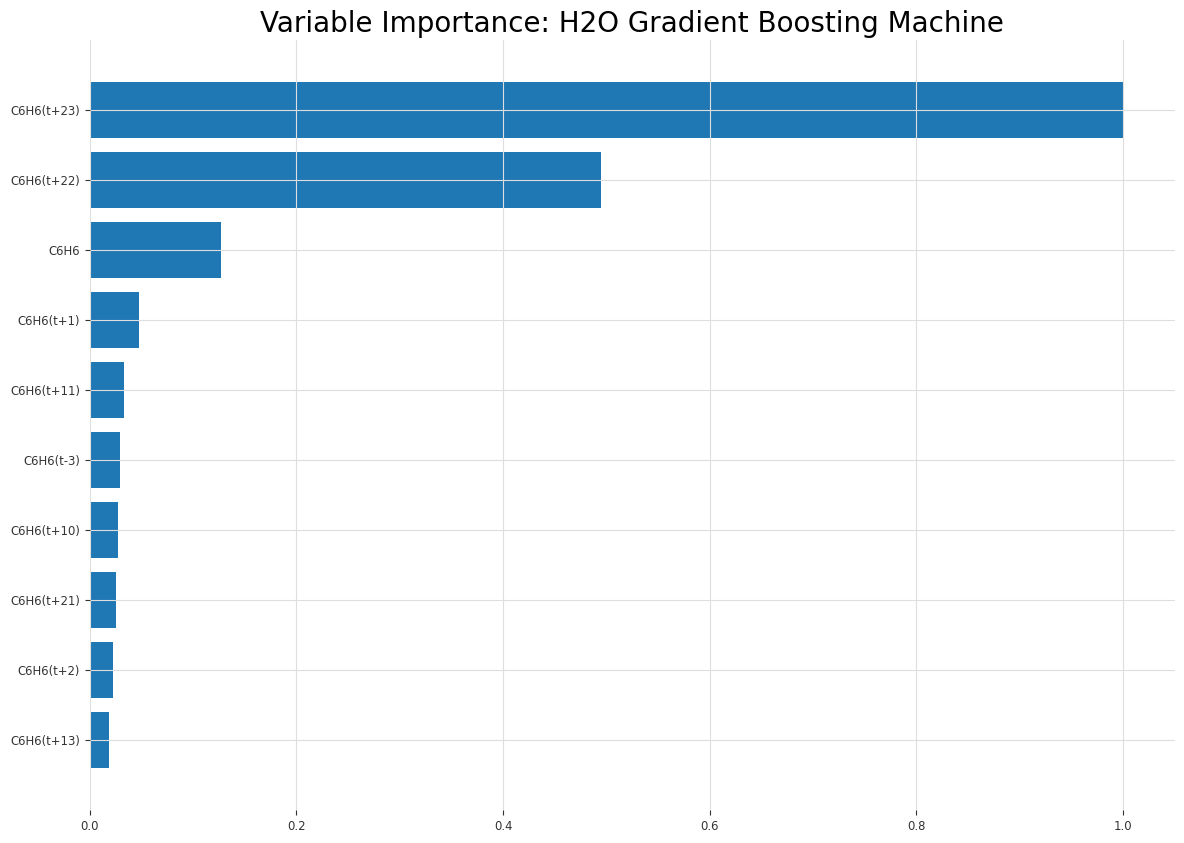

<Figure size 640x480 with 0 Axes>

In [46]:
#Gráfico que muestra la importancia de las variables
salida.varimp_plot()

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

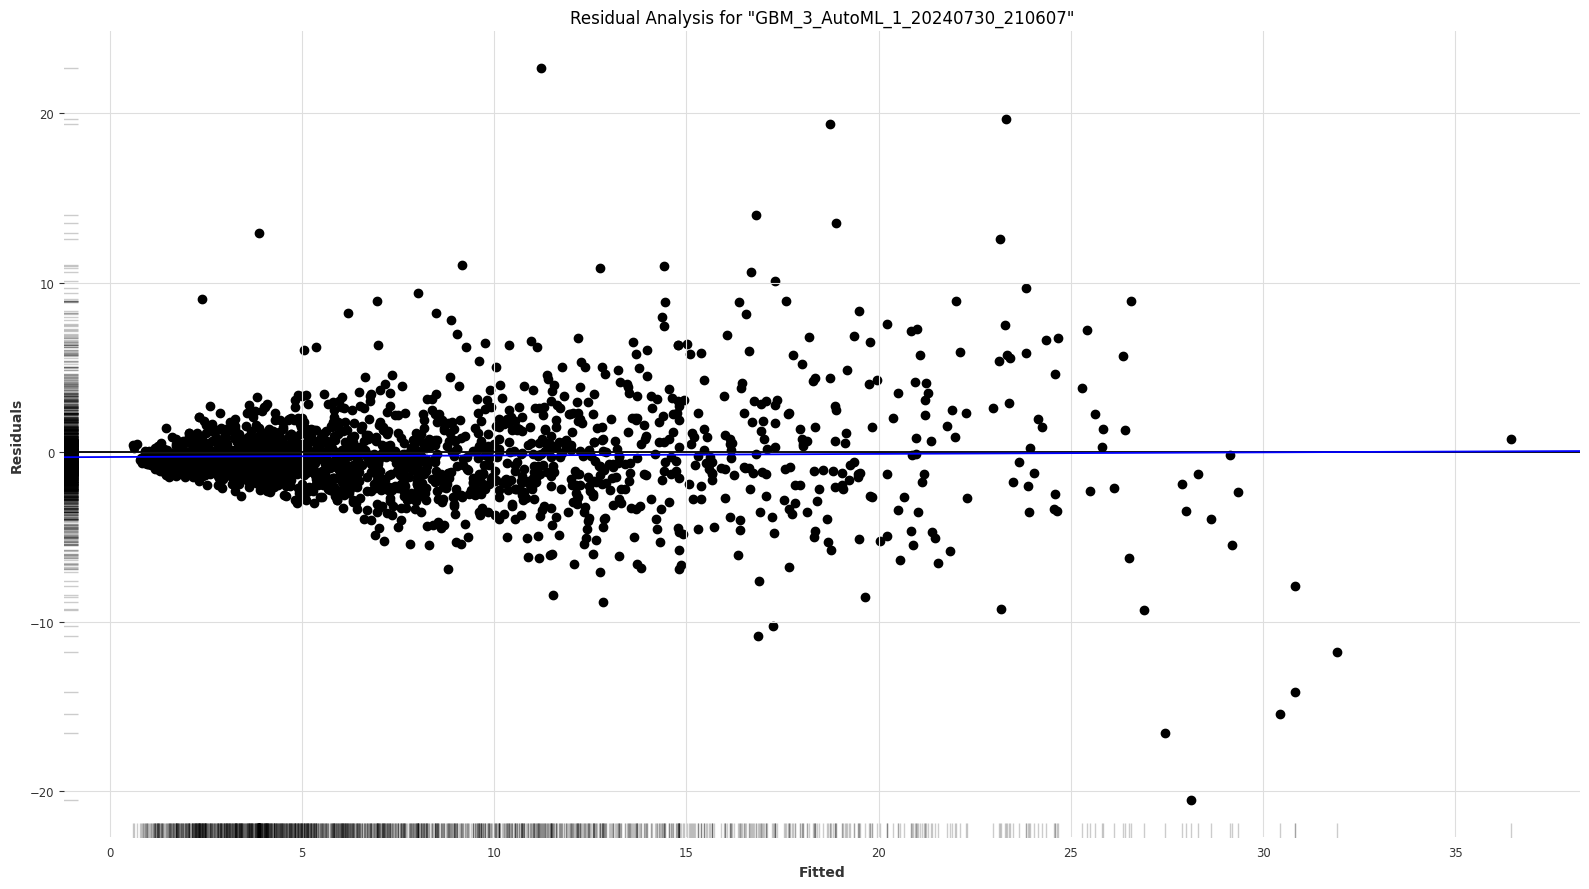

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

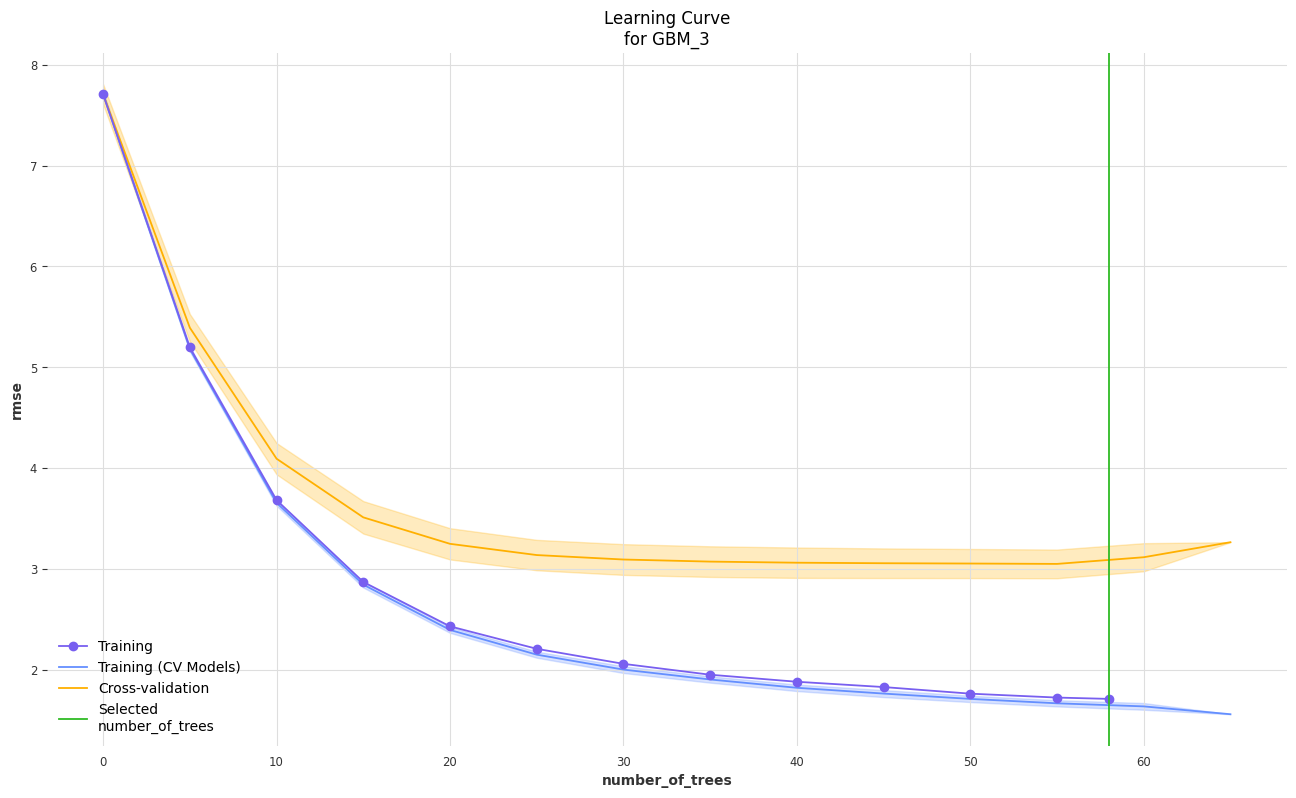

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

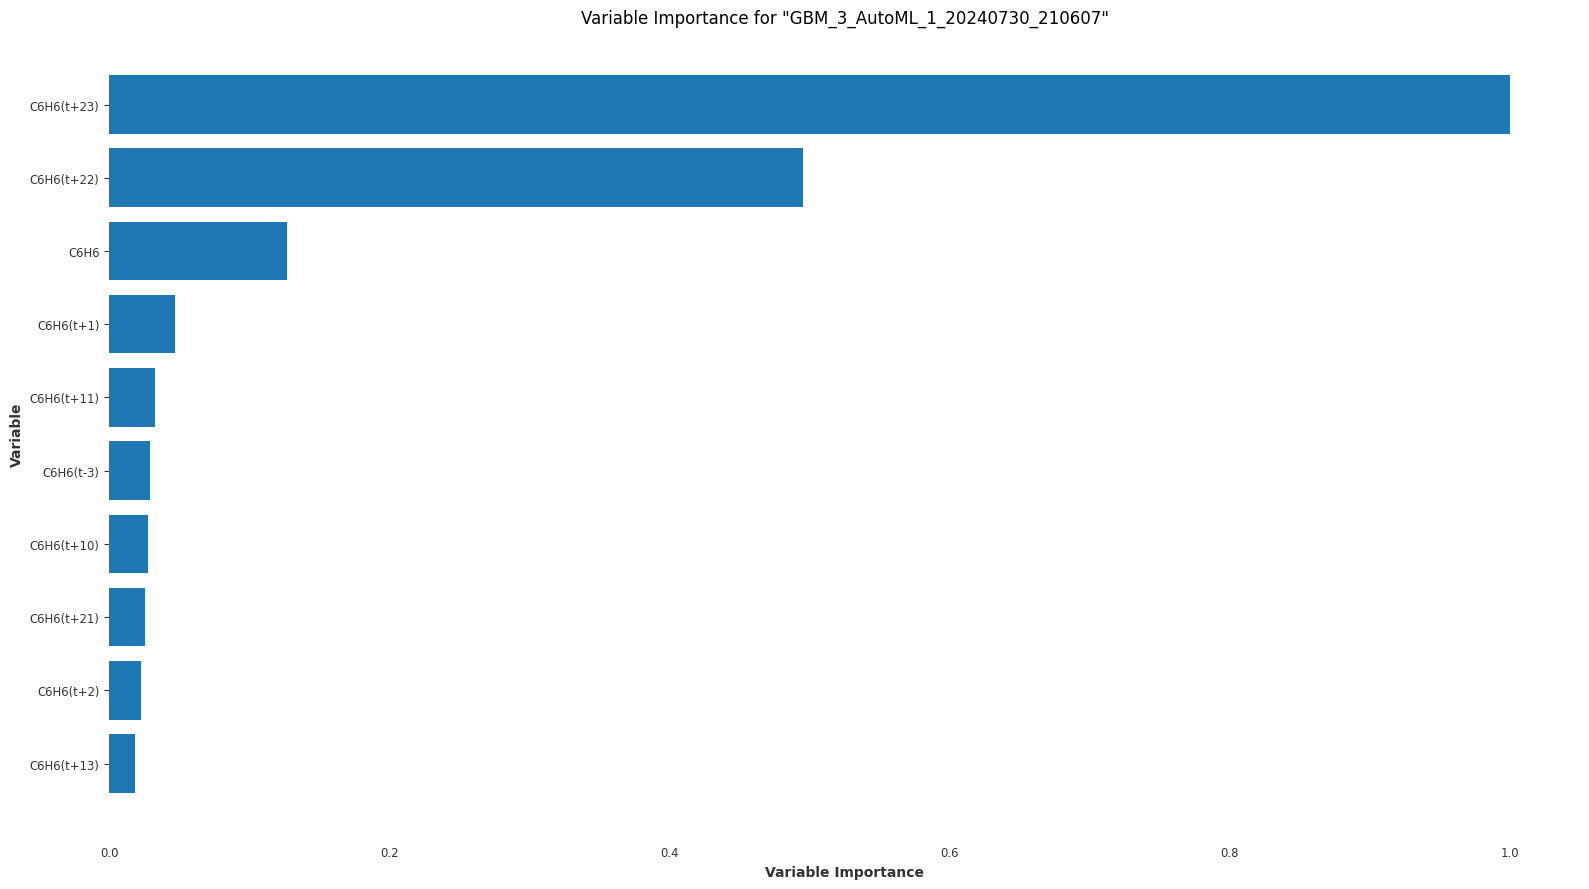

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

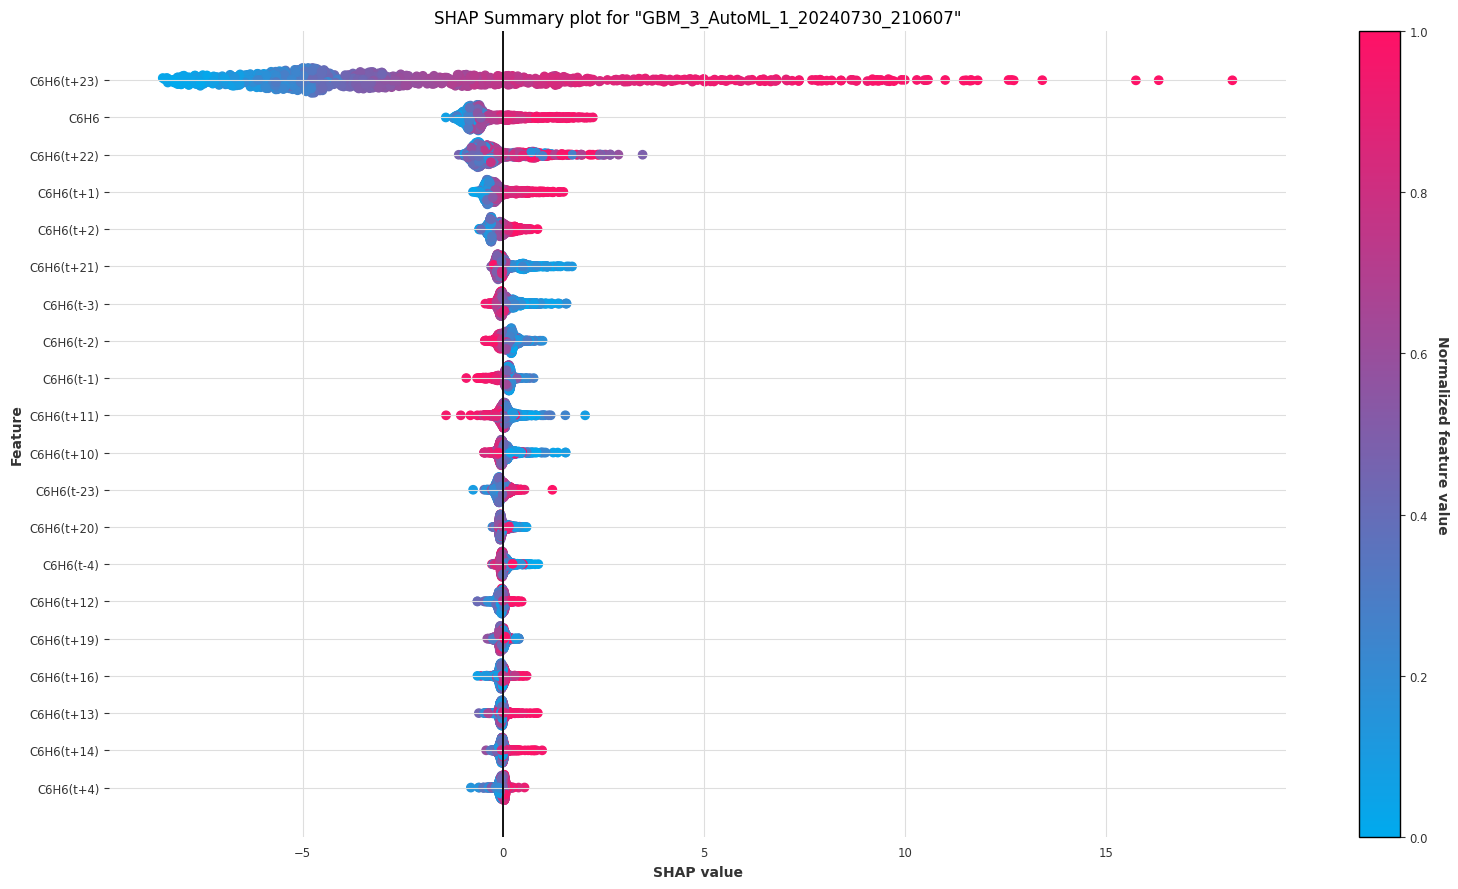

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

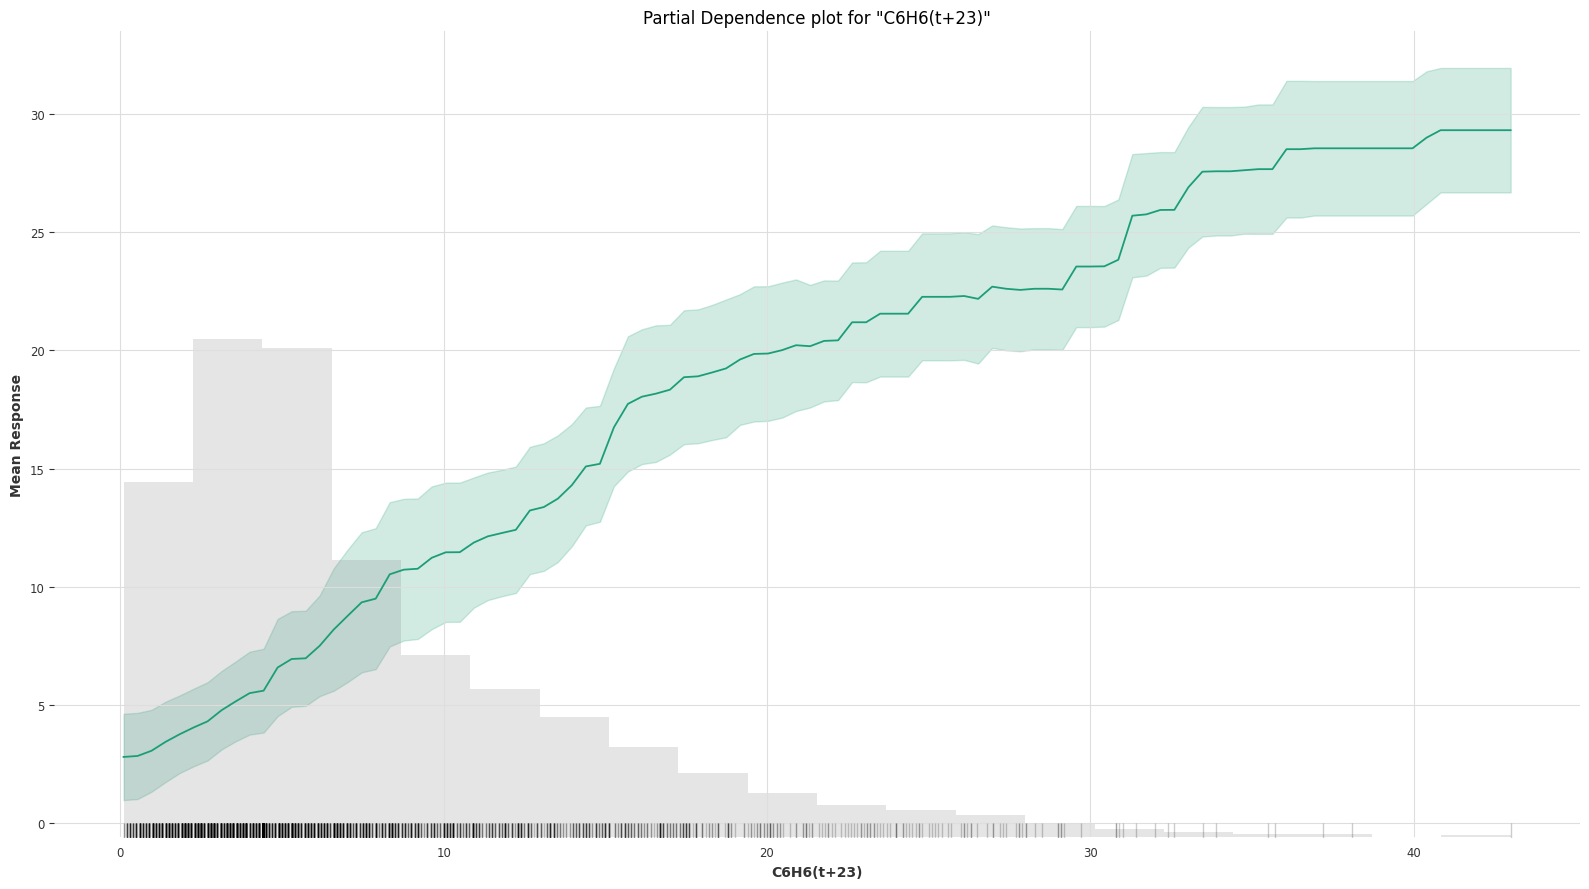

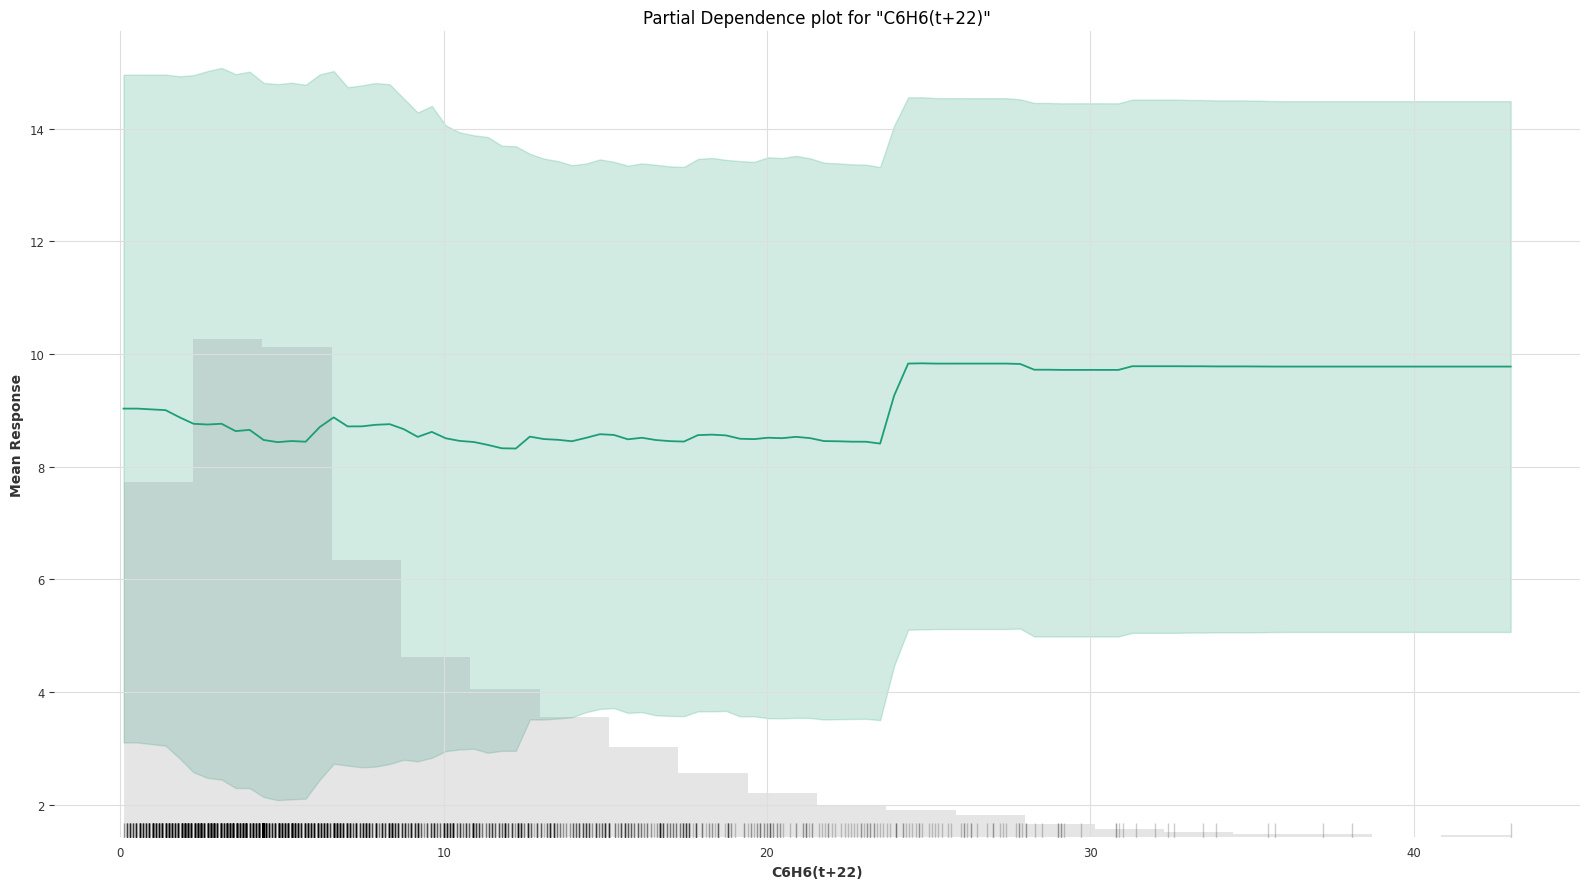

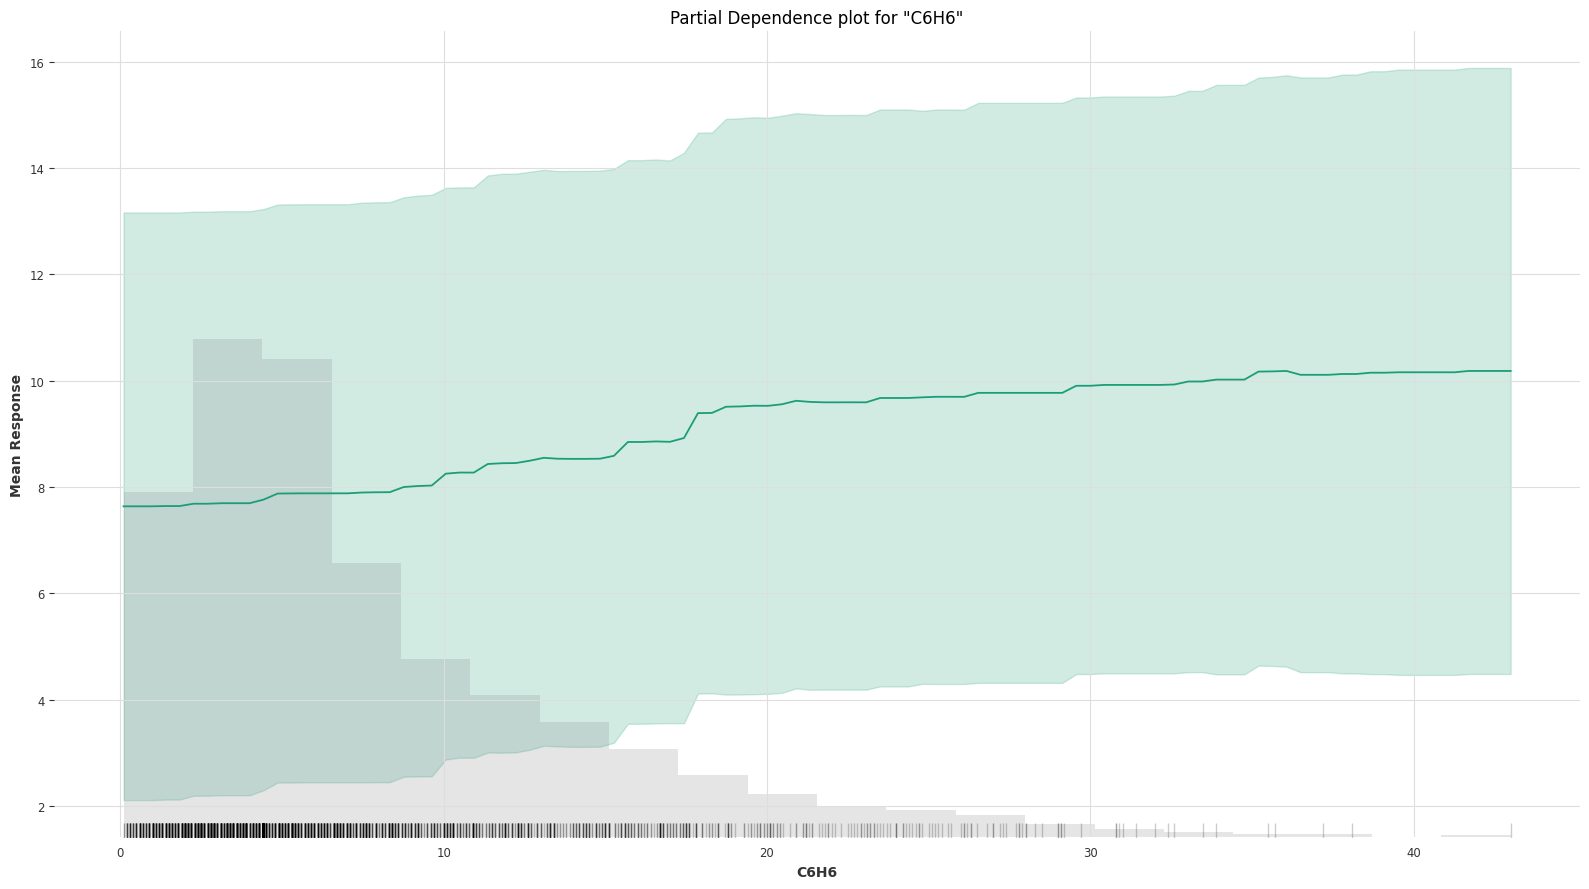

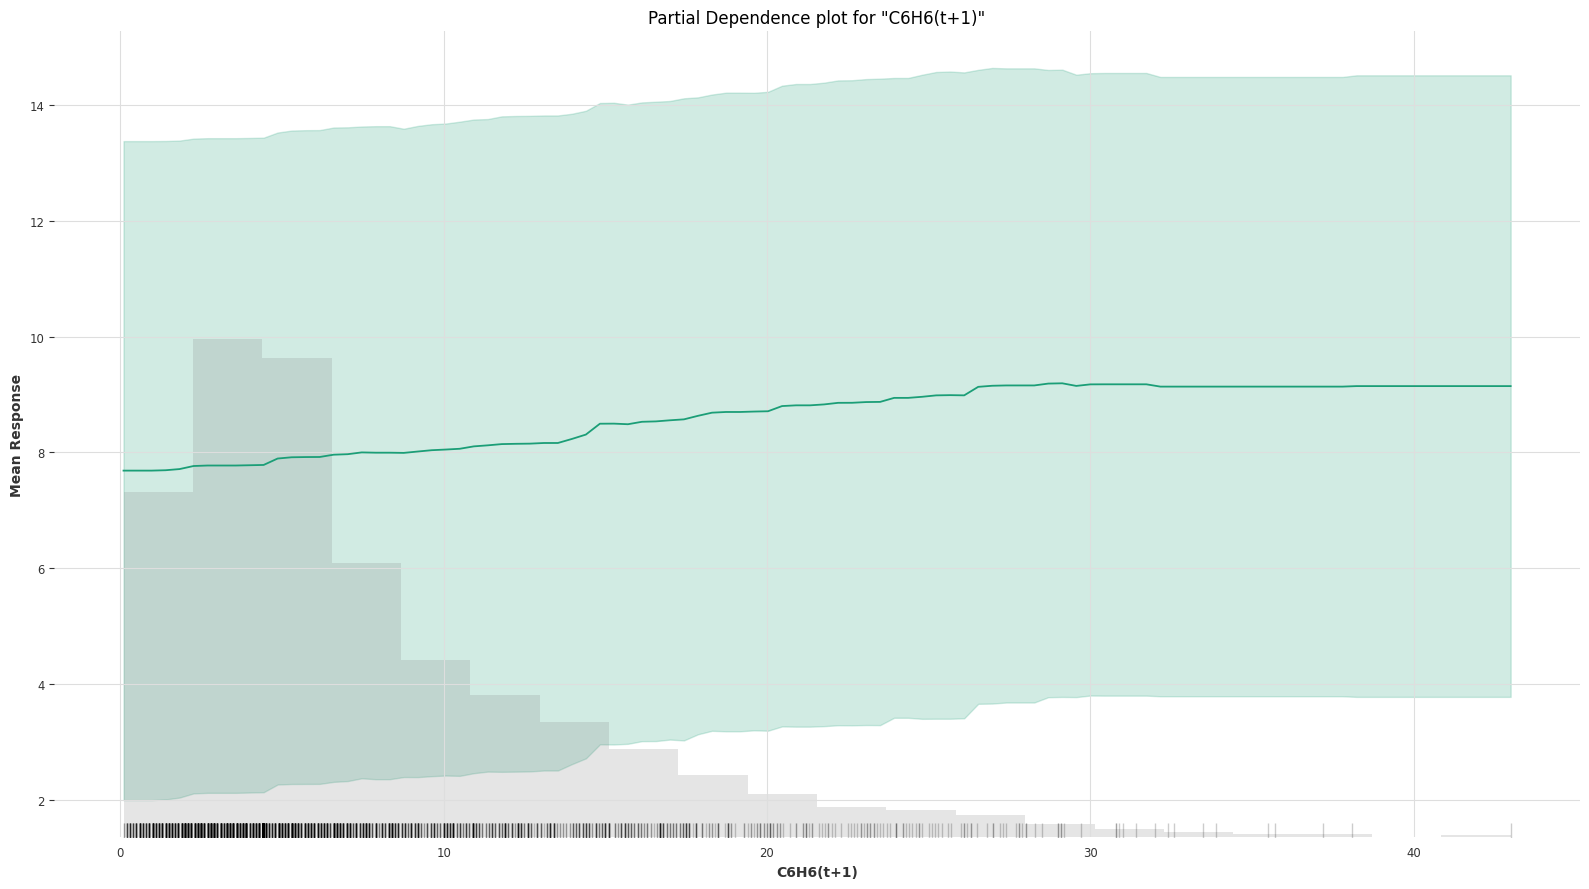

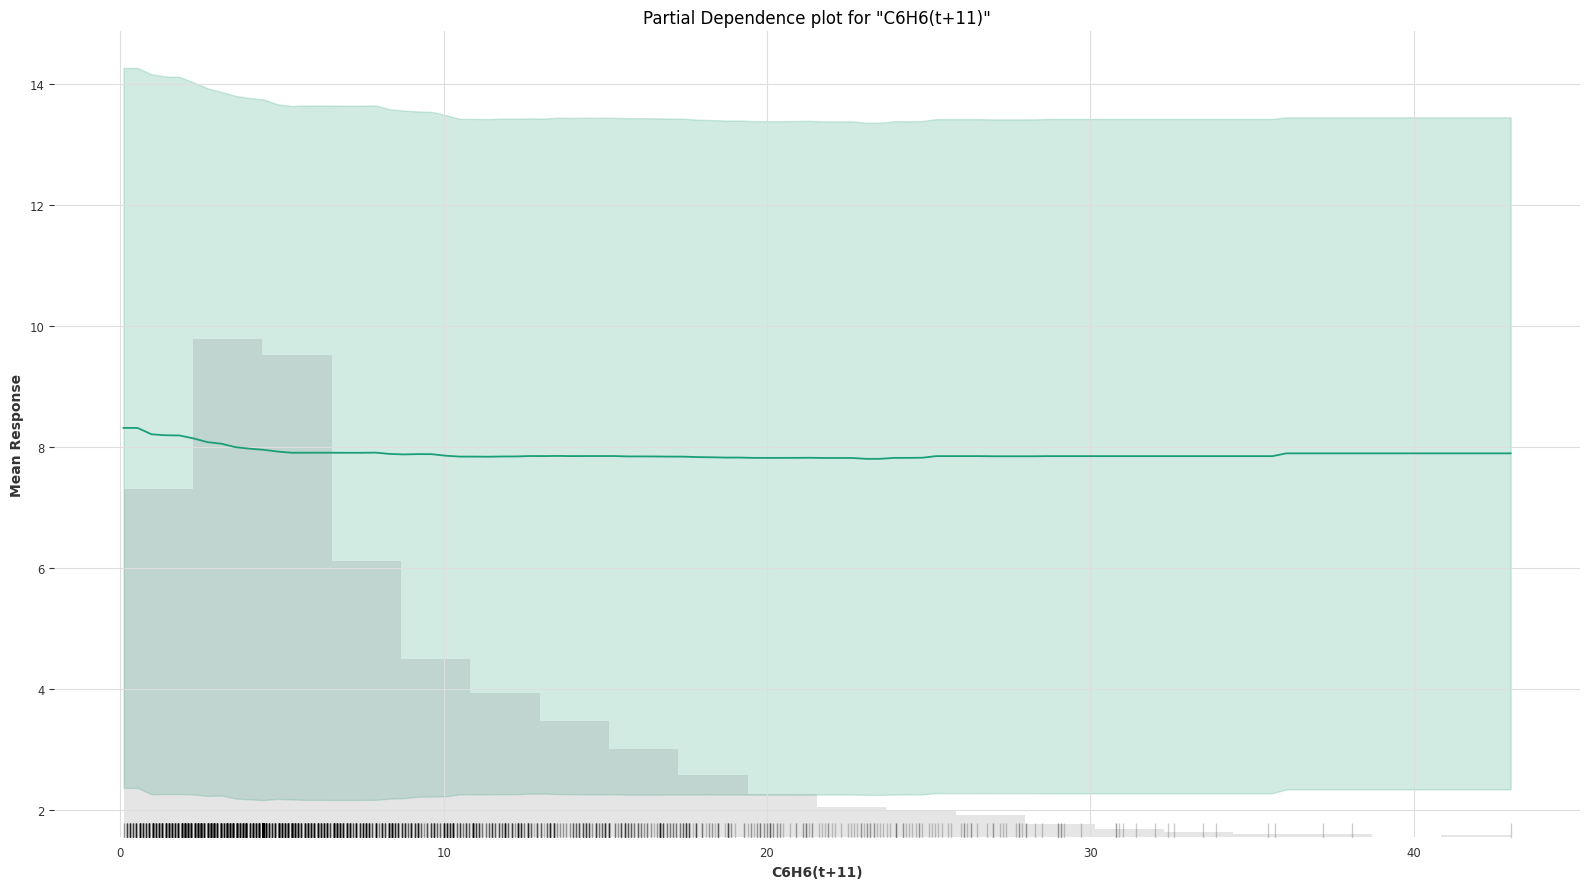

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

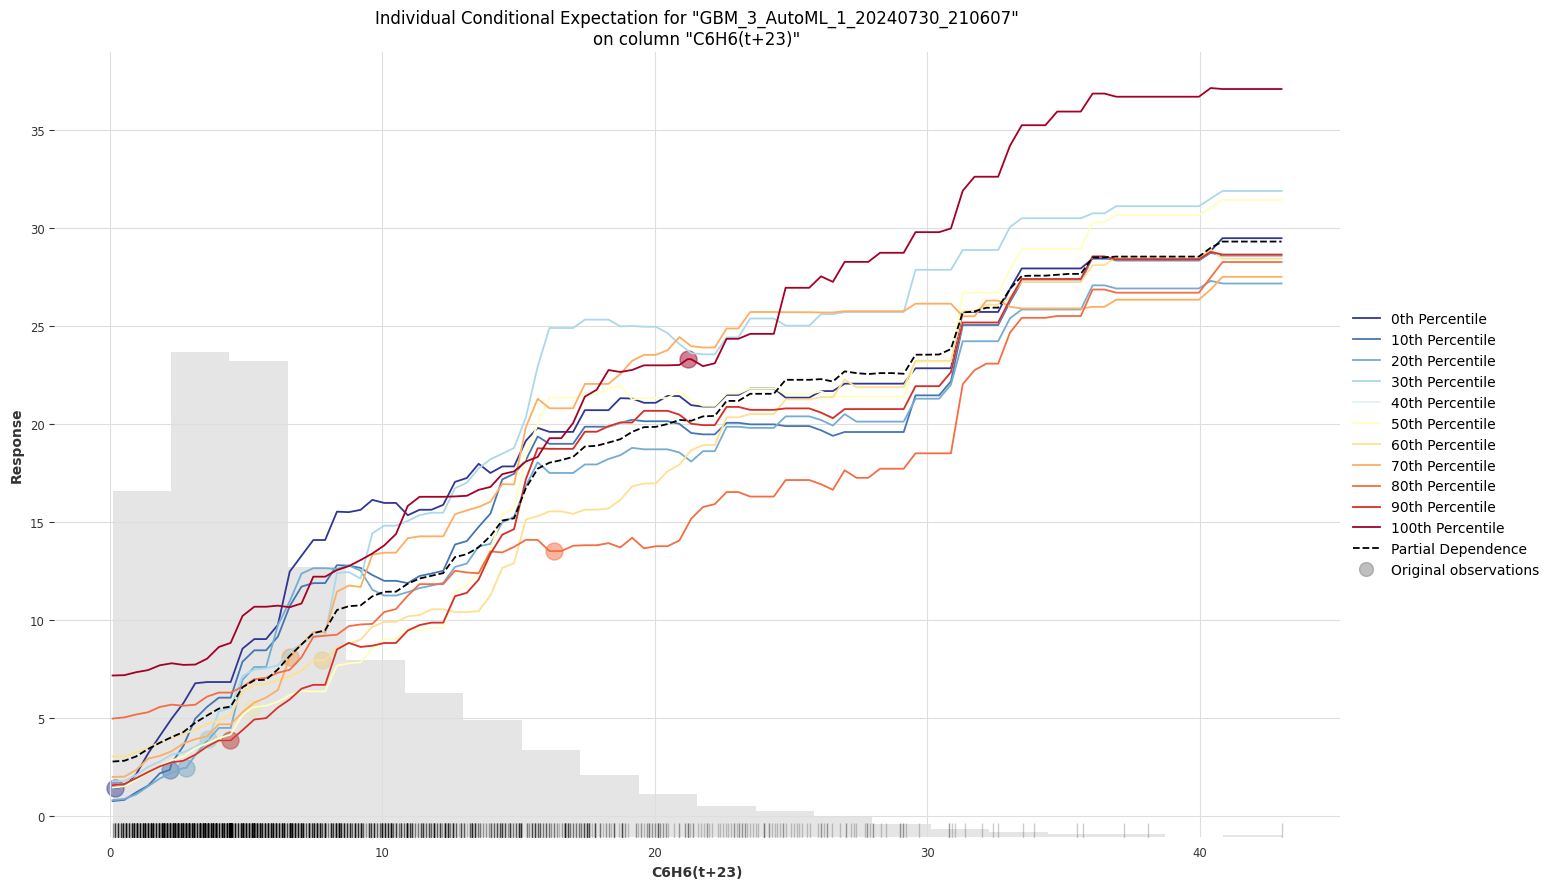

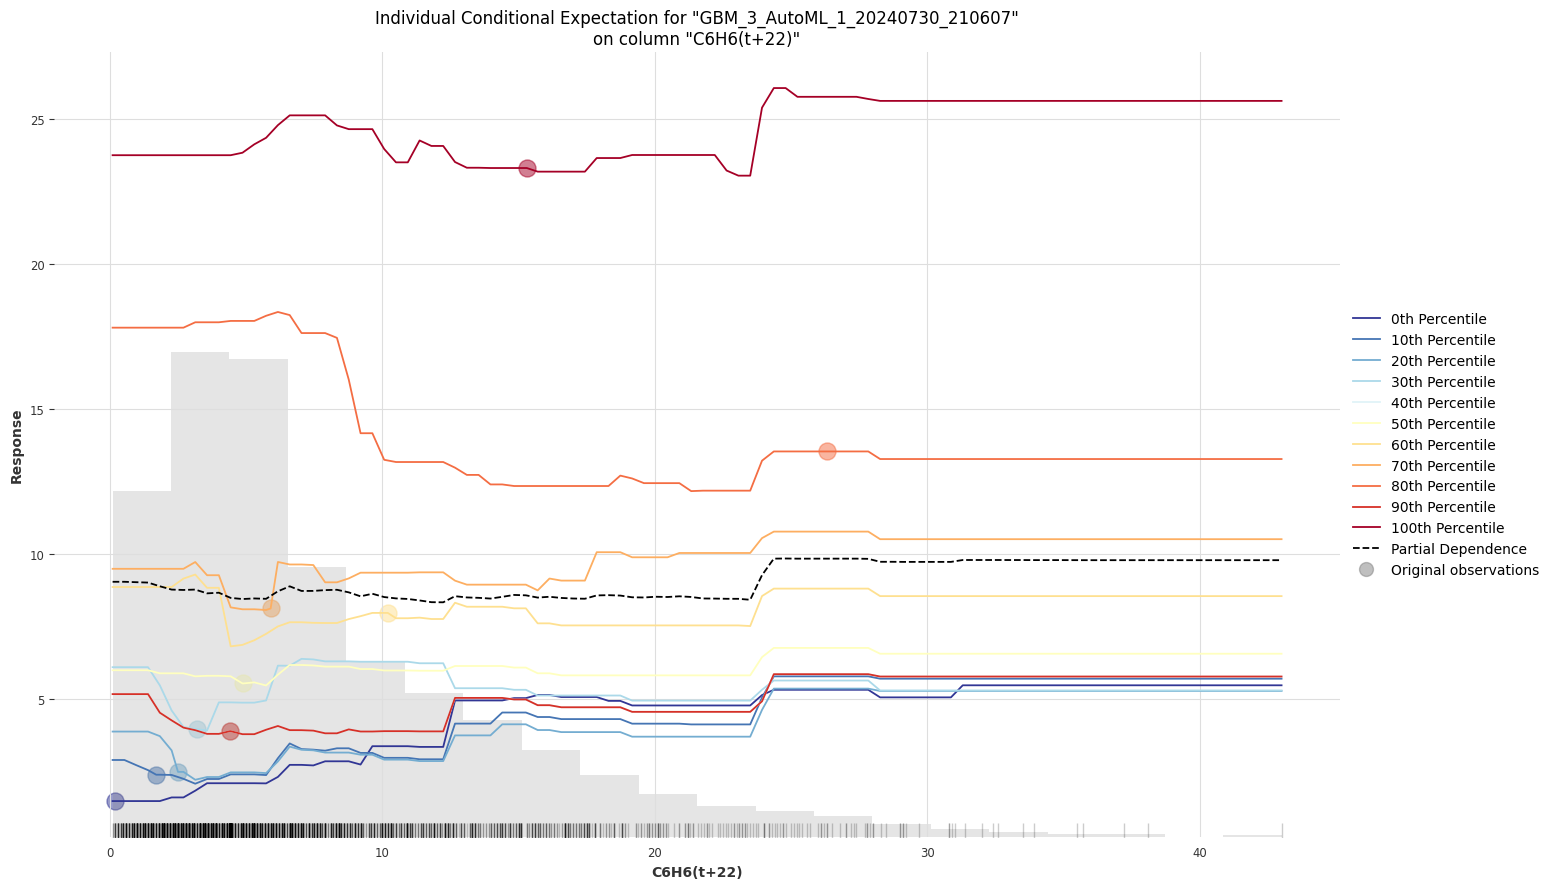

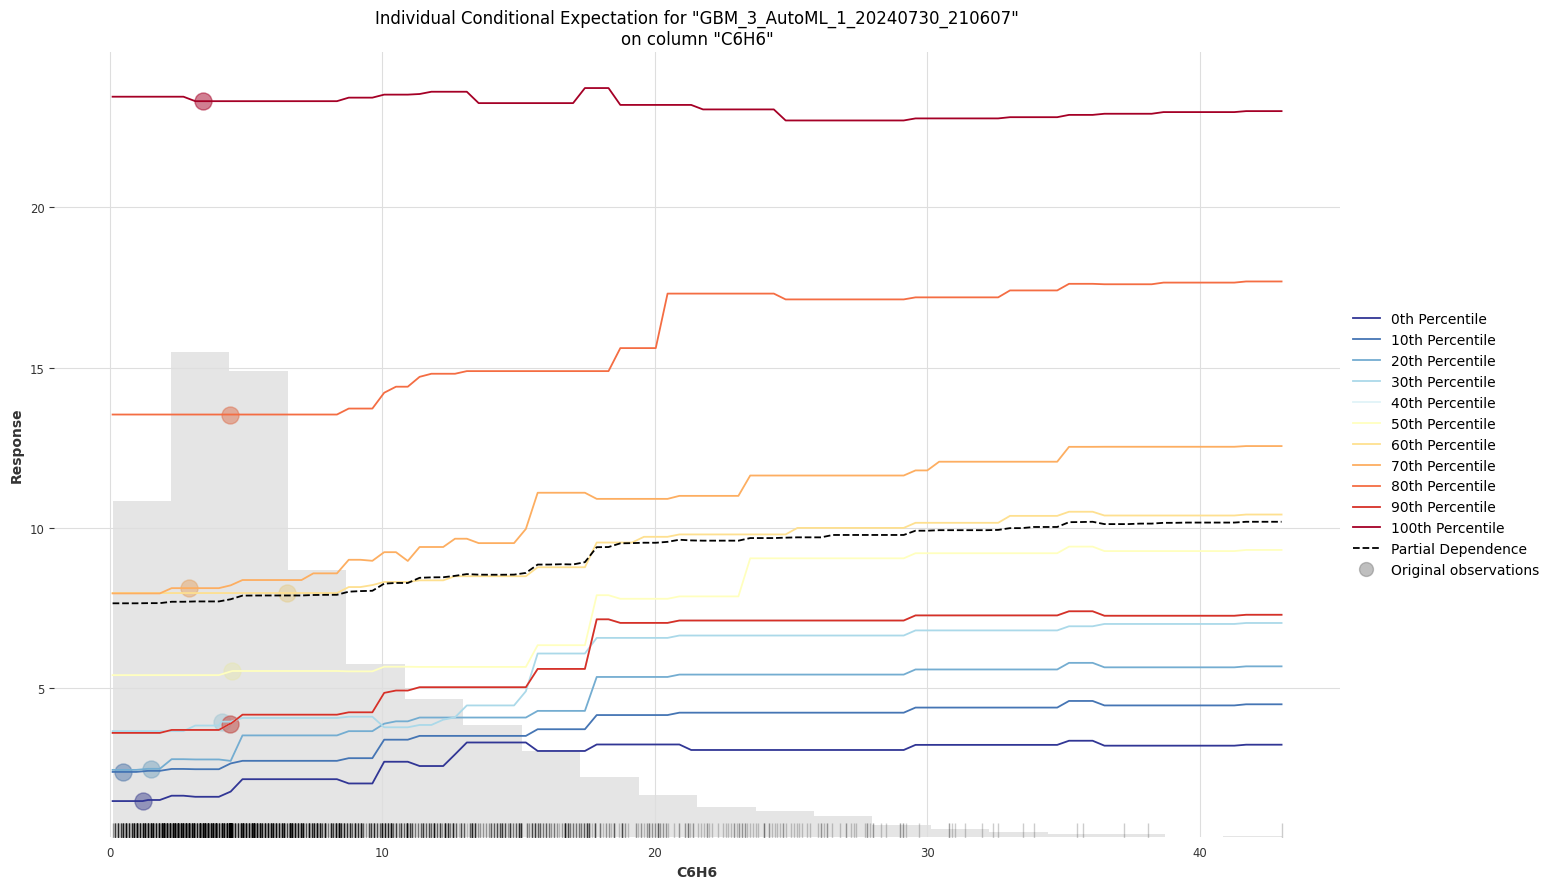

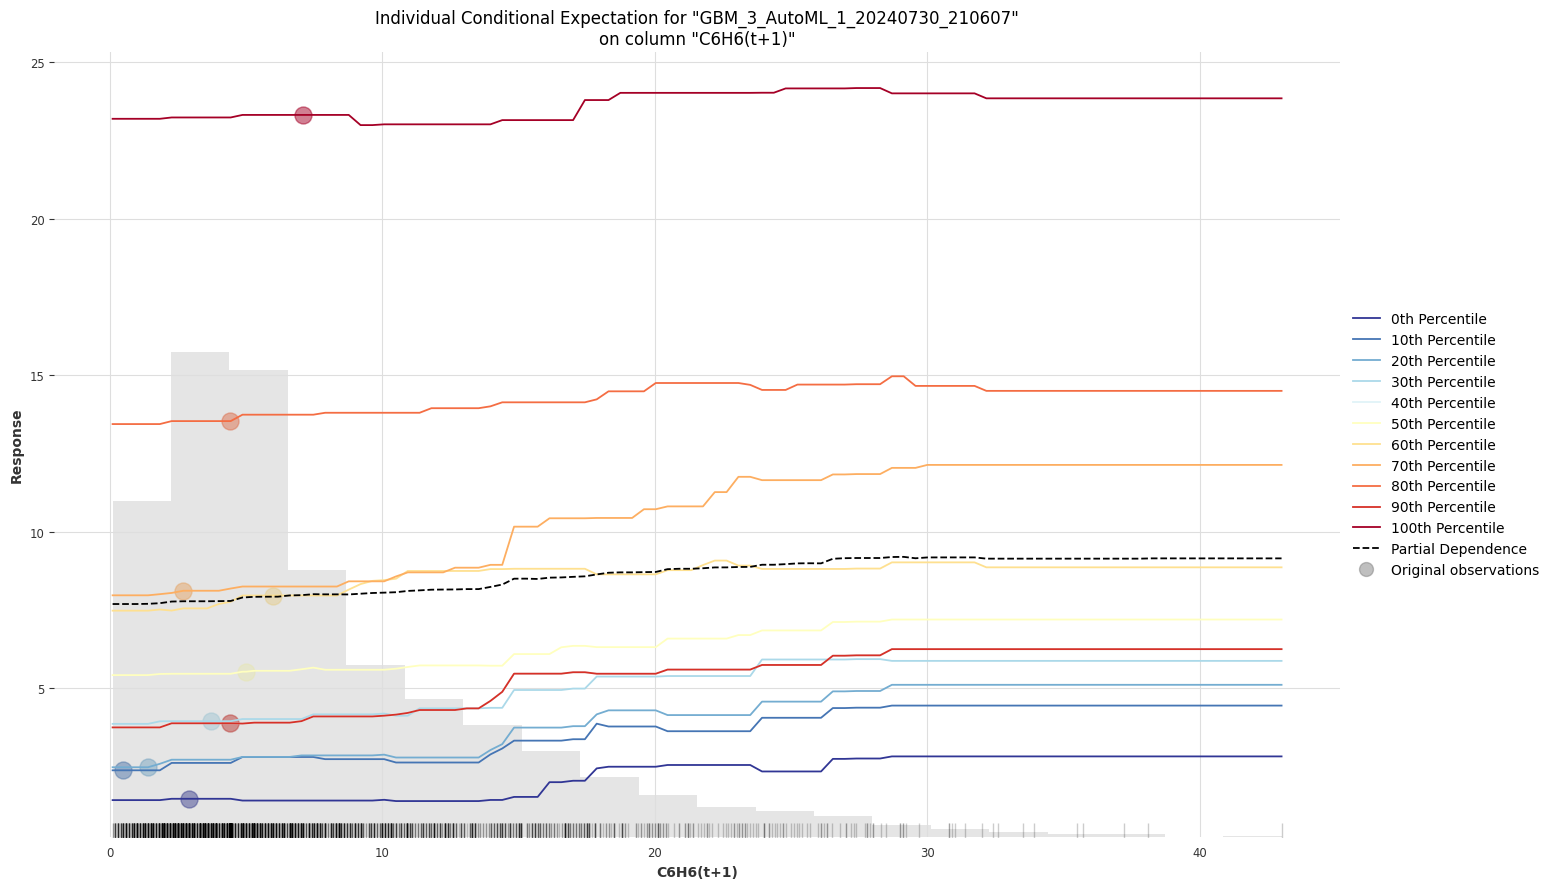

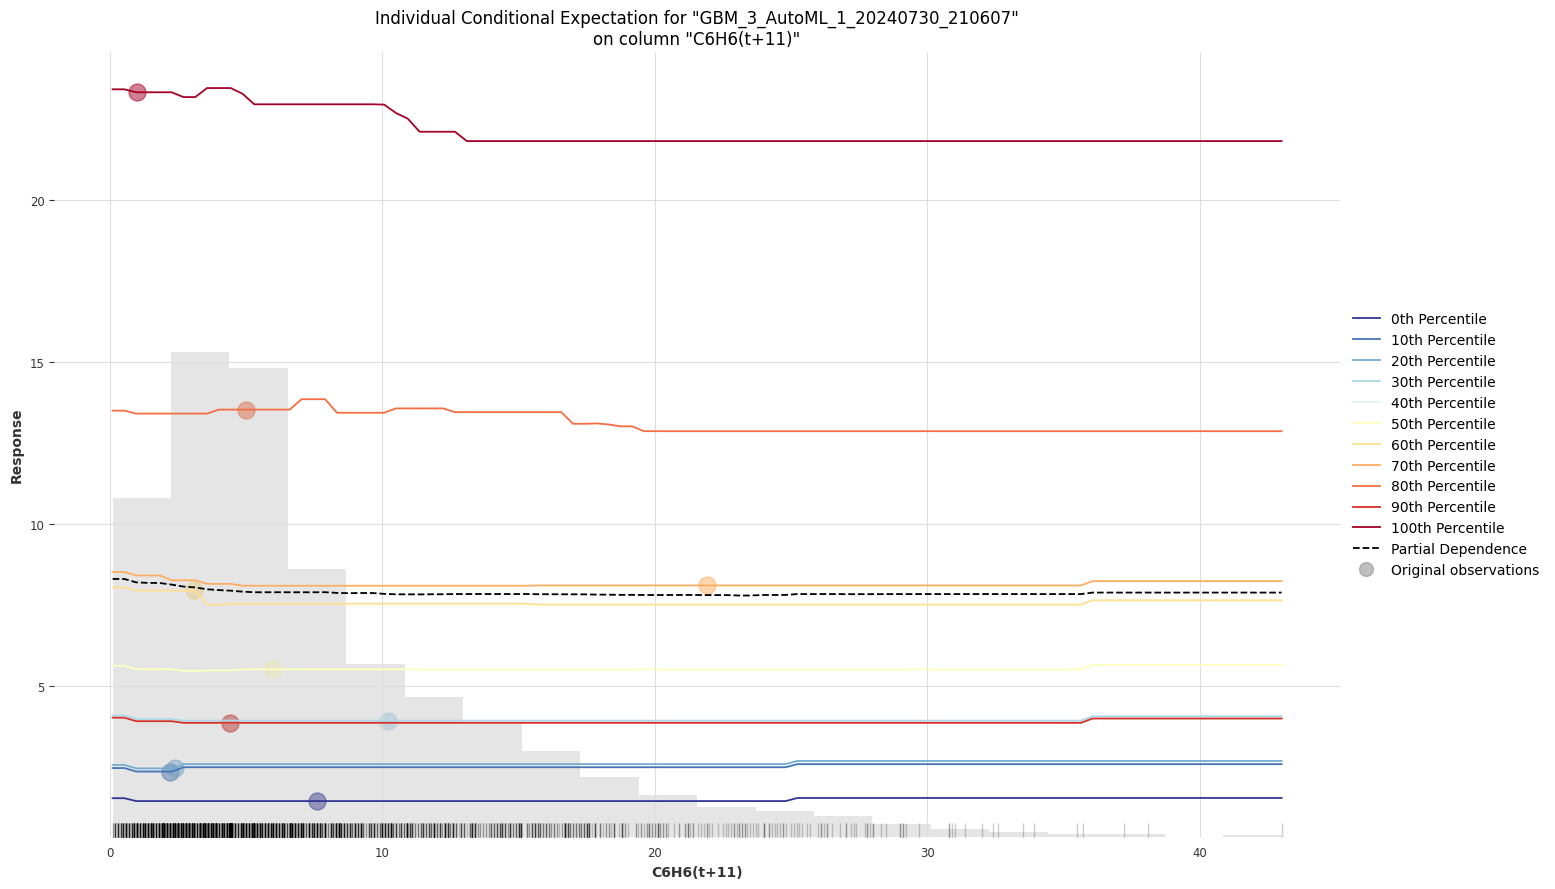

In [48]:
# Graficas para explicación el mejor modelo
exm = aml1.leader.explain(df_test)

**Interpretación de los gráficos**

1. Residual Analysis: los residuos deberian estar distribuidos aleatoriamente alrededor de cero. En este caso se ve como un patron lo que podría indicar que no estaría capturando la variabilidad d elos datos

2. Learning Curve Plot: se puede visualizar cómo cambia el rendimiento del modelo con diferentes iteraciones. Con la separacion de la curva de Training y la de Cross-Validation indica el overfiting

3. Variable Importance: muestra la importancia relativa de las variables más importantes del modelo. Tiene uan escala entre 0 y 1.Se calcula mediante la influencia relativa de cada variable, por ejemplo si esa variable fue elegida para dividirla al construir el árbol y cuánto mejoró (se redujo) el error al cuadrado (árboles en general) como resultado. En este caso la variable más importante es C6H6(t+23) seguida de C6H6 (t+22) y C6H6.

4. SHAP Summary:  interpreta el impacto de tener un valor particular para una variable dada en comparación con la predicción base o prediccion de referenica (es la prediccion del modelo cuando las características están en sus valores promedios o de referencia). Se puede ver cómo la variable C6H6(t+23)

5. Partial Dependence Plots: estos gráficos de dependencia parcial muestran cómo una determinada variable afecta a las predicciones mientras se promedian los efectos de las demás características.

6. Individual Conditional Expectation:explican como variable afecta las predicciones del modelo en diferentes instancias






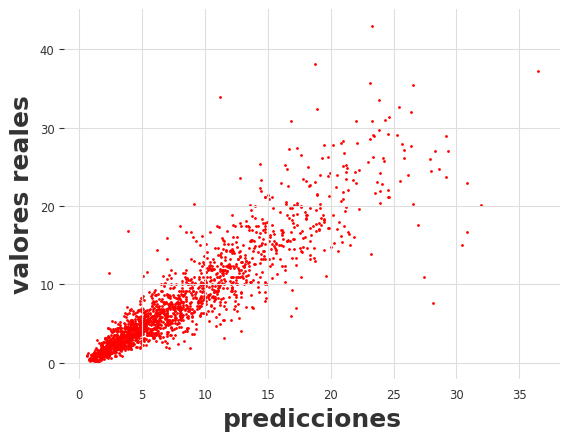

In [ ]:
# Gráfico de dispersión de las predciones y los valores reales
plt.scatter(x=df_results['predicciones'],y=df_results['valores reales'],s=1,c='red')
plt.xlabel('predicciones',fontsize=18)
plt.ylabel('valores reales',fontsize=18)
plt.show()

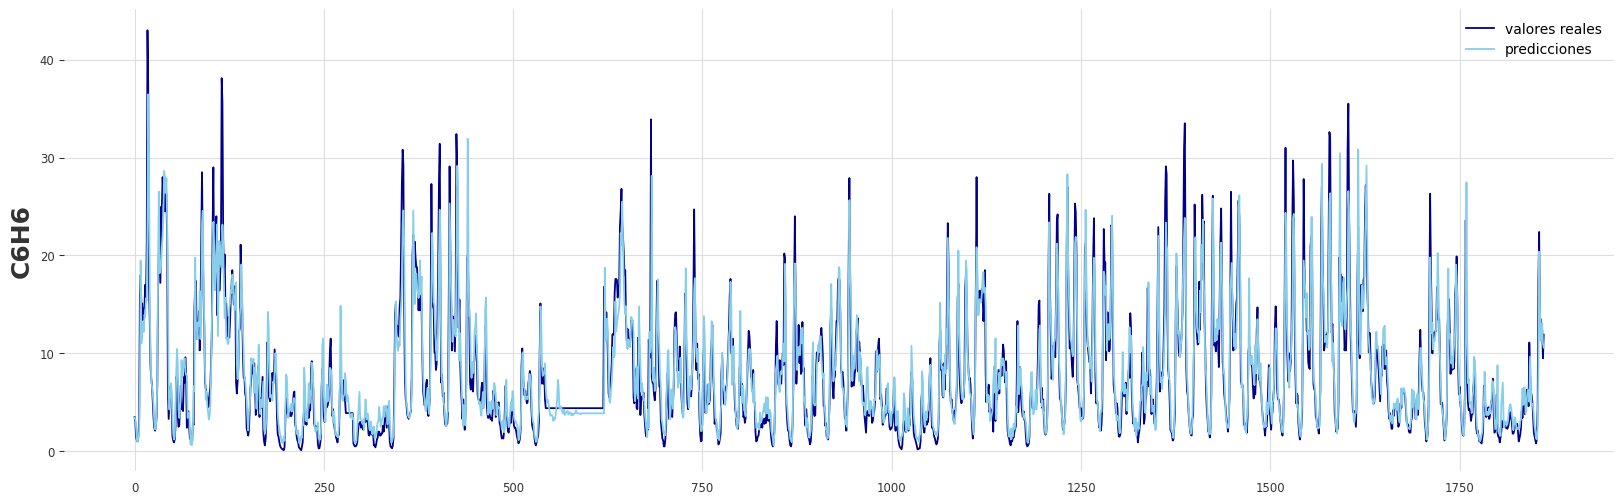

In [ ]:
# Gráfico de las predicciones junto con los valores reales
plt.figure(figsize=(20, 6))
plt.plot(df_results['valores reales'], color='darkblue')
plt.plot(df_results['predicciones'], color='skyblue')
plt.ylabel('C6H6',fontsize=18)
plt.legend(['valores reales','predicciones'])
plt.show()

##**4. H2O Auto ML con las tres series**

Se toman las tres series: C6H6, T, RH. Como target se sigue considerando C6H6(t+24)'

In [12]:
# Se levantan los datos nuevamente según n.1
print(df)

                     C6H6     T    RH
Datetime                             
2004-03-10 18:00:00  11.9  13.6  48.9
2004-03-10 19:00:00   9.4  13.3  47.7
2004-03-10 20:00:00   9.0  11.9  54.0
2004-03-10 21:00:00   9.2  11.0  60.0
2004-03-10 22:00:00   6.5  11.2  59.6
...                   ...   ...   ...
2005-04-04 10:00:00  13.5  21.9  29.3
2005-04-04 11:00:00  11.4  24.3  23.7
2005-04-04 12:00:00  12.4  26.9  18.3
2005-04-04 13:00:00   9.5  28.3  13.5
2005-04-04 14:00:00  11.9  28.5  13.1

[9357 rows x 3 columns]


In [13]:
#Modelado de los datos
def time_series_to_supervised(df, n_lag=24, n_fut=24, selLag=None, selFut=None, dropnan=True):
    n_vars = 1 if type(df) is list else df.shape[1]
    df = DataFrame(df)
    origNames = df.columns
    cols, names = list(), list()

    # incluir todos los atributos del período actual
    cols.append(df.shift(0))
    names += [('%s' % origNames[j]) for j in range(n_vars)]

    # retrasar cualquier atributo del período anterior (t-n_lag,...,t-1)
    n_lag = max(0, n_lag)  # forzar un número válido de períodos de retraso
    for i in range(n_lag, 0, -1):
        suffix = '(t-%d)' % i
        if selLag is None:
            cols.append(df.shift(i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:
            for var in selLag:
                cols.append(df[var].shift(i))
                names += [('%s%s' % (var, suffix))]

    # incluir atributos de período futuro (t+1,...,t+n_fut)
    n_fut = max(n_fut, 0)  # forzar un número válido de períodos futuros para retroceder
    for i in range(1, n_fut + 1):
        suffix = '(t+%d)' % i
        if selFut is None:
            cols.append(df.shift(-i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:  # copiar solo atributos futuros seleccionados
            for var in selFut:
                cols.append(df[var].shift(-i))
                names += [('%s%s' % (var, suffix))]

    # combinar todo
    agg = concat(cols, axis=1)
    agg.columns = names

    # borra filas con valores NaN introducidos por el lagging
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [14]:
# Obtener el dataFrame procesado con los lags (entradas) y lags de (salidas) en un formato que se puede utilizar para entrenamiento de modelos de aprendizaje supervisado.
df_processed = time_series_to_supervised(df, n_lag=24, n_fut=24, selLag=None, selFut=['C6H6'], dropnan=True)
print(df_processed.head())

                     C6H6     T    RH  C6H6(t-24)  T(t-24)  RH(t-24)  \
Datetime                                                               
2004-03-11 18:00:00  20.8  10.3  64.2        11.9     13.6      48.9   
2004-03-11 19:00:00  27.4   9.7  69.3         9.4     13.3      47.7   
2004-03-11 20:00:00  24.0   9.6  67.8         9.0     11.9      54.0   
2004-03-11 21:00:00  12.8   9.1  64.0         9.2     11.0      60.0   
2004-03-11 22:00:00   4.7   8.2  63.4         6.5     11.2      59.6   

                     C6H6(t-23)  T(t-23)  RH(t-23)  C6H6(t-22)  ...  \
Datetime                                                        ...   
2004-03-11 18:00:00         9.4     13.3      47.7         9.0  ...   
2004-03-11 19:00:00         9.0     11.9      54.0         9.2  ...   
2004-03-11 20:00:00         9.2     11.0      60.0         6.5  ...   
2004-03-11 21:00:00         6.5     11.2      59.6         4.7  ...   
2004-03-11 22:00:00         4.7     11.2      59.2         3.6  ...  

In [15]:
# Separación en entrenamiento (80%) y testeo (20%)
df_processed.reset_index(drop=True,inplace=True) # reseteo el índice
df_train = df_processed.loc[:int(df_processed.shape[0]*0.8),:]
df_test = df_processed.loc[int(df_processed.shape[0]*0.8):,:]

In [16]:
# Inicialización de sesión
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.23" 2024-04-16; OpenJDK Runtime Environment (build 11.0.23+9-post-Ubuntu-1ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 11.0.23+9-post-Ubuntu-1ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp1p88v9e5
  JVM stdout: /tmp/tmp1p88v9e5/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp1p88v9e5/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         04 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.4
H2O_cluster_version_age:    21 days, 5 hours and 43 minutes
H2O_cluster_name:           H2O_from_python_unknownUser_kf6i15
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.170 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

In [17]:
# Se convierten los dataframe de pandas en h2o frames
df_train = h2o.H2OFrame(df_train)
df_test = h2o.H2OFrame(df_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [18]:
# Se define el target (variable a predecir) y la base de entrenamiento
y = 'C6H6(t+24)'
X = df_train.columns
X.remove(y)

In [19]:
aml3 = H2OAutoML(max_models=10, max_runtime_secs = 360,seed = 42, verbosity="info", exclude_algos=['StackedEnsemble'])

In [20]:
# Inicio del entrenamiento
aml3.train(x = X,
          y = y,
          training_frame = df_train,
          leaderboard_frame = df_test)

AutoML progress: |
01:57:47.461: Project: AutoML_1_20240731_15747
01:57:47.487: 5-fold cross-validation will be used.
01:57:47.488: Setting stopping tolerance adaptively based on the training frame: 0.011587244366483038
01:57:47.488: Build control seed: 42
01:57:47.493: training frame: Frame key: AutoML_1_20240731_15747_training_Key_Frame__upload_824faaacdad859c67177987a8fae4eba.hex    cols: 99    rows: 7448  chunks: 1    size: 1483020  checksum: 2681332268245736000
01:57:47.493: validation frame: NULL
01:57:47.494: leaderboard frame: Frame key: Key_Frame__upload_9d755e6006a893b0300d2316f54543a2.hex    cols: 99    rows: 1862  chunks: 1    size: 376992  checksum: 409957949129418496
01:57:47.494: blending frame: NULL
01:57:47.494: response column: C6H6(t+24)
01:57:47.494: fold column: null
01:57:47.530: weights column: null
01:57:47.698: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_1_20240731_15747


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    83                 83                          48597                  8            15           13.3855       24            49            41.6868

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 5.724891905112955
RMSE: 2.3926746341934906
MAE: 1.587376932718588
RMSLE: 0.19214066609054317
Mean Residual Deviance: 5.724891905112955

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 9.301130013617337
RMSE: 3.0497754037989973
MAE: 2.0327415424118693
RMSLE: 0.24306236996069638
Mean Residual Deviance: 9.301130013617337

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
aic                     nan       0           nan           nan           nan           nan           nan
loglikelihood           nan       0           nan           nan           nan           nan           nan
mae                     2.03267   0.04668     2.01584       2.05971       2.08999       1.96623       2.0316
mean_residual_deviance  9.31234   0.88368     9.16317       9.69358       10.6156       8.34631       8.743
mse                     9.31234   0.88368     9.16317       9.69358       10.6156       8.34631       8.743
r2                      0.843462  0.0104745   0.843317      0.840375      0.827896      0.855136      0.850585
residual_deviance       9.31234   0.88368     9.16317       9.69358       10.6156       8.34631       8.743
rmse                    3.04891   0.143593    3.02707       3.11345       3.25817       2.889         2.95686
rmsle                   0.243237  0.00546568  0.243228      0.246843      0.250288      0.237691      0.238135

Scoring History: 
    timestamp            duration          number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------------  -----------------  ---------------  --------------  -------------------
    2024-07-31 01:59:58  1 min 17.843 sec  0                  7.70748          5.99567         59.4053
    2024-07-31 02:00:00  1 min 19.438 sec  5                  5.55002          4.18132         30.8028
    2024-07-31 02:00:01  1 min 20.322 sec  10                 4.24559          3.08473         18.0251
    2024-07-31 02:00:02  1 min 20.984 sec  15                 3.57111          2.50661         12.7528
    2024-07-31 02:00:02  1 min 21.658 sec  20                 3.22005          2.19125         10.3687
    2024-07-31 02:00:03  1 min 22.508 sec  25                 3.01444          2.01713         9.08688
    2024-07-31 02:00:04  1 min 23.398 sec  30                 2.90174          1.92608         8.42008
    2024-07-31 02:00:04  1 min 23.975 sec  35                 2.81104          1.85539         7.90194
    2024-07-31 02:00:05  1 min 24.824 sec  40                 2.73549          1.80368         7.48289
    2024-07-31 02:00:06  1 min 25.645 sec  45                 2.68431          1.76917         7.20554
    2024-07-31 02:00:07  1 min 26.407 sec  50                 2.63611          1.73931         6.94909
    2024-07-31 02:00:08  1 min 27.301 sec  55                 2.5923           1.71382         6.72002
    2024-07-31 02:00:09  1 min 28.022 sec  60                 2.55077          1.68735         6.50643
    2024-07-31 02:00:09  1 min 28.823 sec  65                 2.51766          1.66491         6.33863
    2024-07-31 02:00:10  1 min 29.690 sec  70         

In [21]:
lb3 = aml3.leaderboard
lb3

model_id                              rmse       mse      mae       rmsle    mean_residual_deviance
---------------------------------  -------  --------  -------  ----------  ------------------------
GBM_1_AutoML_1_20240731_15747      2.88275   8.31024  1.9396     0.313564                   8.31024
GLM_1_AutoML_1_20240731_15747      2.99438   8.96633  2.01315  nan                          8.96633
XGBoost_1_AutoML_1_20240731_15747  3.30355  10.9135   2.2849     0.382319                  10.9135
XGBoost_2_AutoML_1_20240731_15747  3.35923  11.2844   2.22976  nan                         11.2844
[4 rows x 6 columns]

In [22]:
# Elección del mejor modelo
mejor_modelo3= aml3.leader

In [24]:
# Predicciones en el df_test
df_test_predict = mejor_modelo3.predict(df_test)
print(df_test_predict)


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
  predict
 3.07462
 2.77814
 2.7055
 1.67753
 0.908249
 1.39666
 2.4348
 6.74396
20.7351
14.8649
[1862 rows x 1 column]



In [25]:
# Convertir el H2OFrame de df_test a DataFrame de pandas
df_test_pandas = df_test.as_data_frame(use_multi_thread=True) #el argumento es para que sea más rápido
df_test_pandas.head()

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


C6H6    T    RH  C6H6(t-24)  T(t-24)  RH(t-24)  C6H6(t-23)  T(t-23)  \
0   9.8  4.9  67.1         7.5      4.9      80.1         6.2      4.8   
1   7.6  5.1  65.5         6.2      4.8      79.4         5.1      3.3   
2   6.0  4.0  69.5         5.1      3.3      82.6         4.8      2.4   
3   5.9  3.7  68.9         4.8      2.4      86.6         3.1      3.4   
4   4.2  4.5  62.7         3.1      3.4      81.4         2.8      4.2   

   RH(t-23)  C6H6(t-22)  ...  C6H6(t+15)  C6H6(t+16)  C6H6(t+17)  C6H6(t+18)  \
0      79.4         5.1  ...         2.8         3.3         3.4         7.1   
1      82.6         4.8  ...         3.3         3.4         7.1         7.4   
2      86.6         3.1  ...         3.4         7.1         7.4         4.3   
3      81.4         2.8  ...         7.1         7.4         4.3         3.9   
4      77.0         4.3  ...         7.4         4.3         3.9         5.2   

   C6H6(t+19)  C6H6(t+20)  C6H6(t+21)  C6H6(t+22)  C6H6(t+23)  C6H6(t+24)  
0         7.4         4.3         3.9         5.2         3.8         3.5  
1         4.3         3.9         5.2         3.8         3.5         2.9  
2         3.9         5.2         3.8         3.5         2.9         1.4  
3         5.2         3.8         3.5         2.9         1.4         1.1  
4         3.8         3.5         2.9         1.4         1.1         1.0  

[5 rows x 99 columns]

In [26]:
#Predicción vs Valores Reales
df_results = pd.DataFrame()
df_results['valores reales'] = df_test_pandas['C6H6(t+24)'].reset_index(drop=True) # valores reales
df_results['predicciones'] = h2o.as_list(df_test_predict, use_pandas=True) # predicciones
df_results.head()

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


valores reales  predicciones
0             3.5      3.074625
1             2.9      2.778141
2             1.4      2.705497
3             1.1      1.677530
4             1.0      0.908249

In [27]:
# Medidas de precisión en el df_tes
performance = aml3.leader.model_performance(df_test) #al mejor modelo según entrenamiento GBM le calcula la performance en el df_test
performance

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 8.310243390880698
RMSE: 2.8827492764513356
MAE: 1.939597931935109
RMSLE: 0.31356401676778667
Mean Residual Deviance: 8.310243390880698

In [28]:
# Listado de todos los modelos entrenados
model_ids = list(aml3.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_ids

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


['GBM_1_AutoML_1_20240731_15747',
 'GLM_1_AutoML_1_20240731_15747',
 'XGBoost_1_AutoML_1_20240731_15747',
 'XGBoost_2_AutoML_1_20240731_15747']

In [29]:
# Obtener los detalles del modelo específico identificado como GBM_1...
h2o.get_model([mid for mid in model_ids if "GBM_1" in mid][0])

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_1_20240731_15747


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    83                 83                          48597                  8            15           13.3855       24            49            41.6868

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 5.724891905112955
RMSE: 2.3926746341934906
MAE: 1.587376932718588
RMSLE: 0.19214066609054317
Mean Residual Deviance: 5.724891905112955

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 9.301130013617337
RMSE: 3.0497754037989973
MAE: 2.0327415424118693
RMSLE: 0.24306236996069638
Mean Residual Deviance: 9.301130013617337

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
aic                     nan       0           nan           nan           nan           nan           nan
loglikelihood           nan       0           nan           nan           nan           nan           nan
mae                     2.03267   0.04668     2.01584       2.05971       2.08999       1.96623       2.0316
mean_residual_deviance  9.31234   0.88368     9.16317       9.69358       10.6156       8.34631       8.743
mse                     9.31234   0.88368     9.16317       9.69358       10.6156       8.34631       8.743
r2                      0.843462  0.0104745   0.843317      0.840375      0.827896      0.855136      0.850585
residual_deviance       9.31234   0.88368     9.16317       9.69358       10.6156       8.34631       8.743
rmse                    3.04891   0.143593    3.02707       3.11345       3.25817       2.889         2.95686
rmsle                   0.243237  0.00546568  0.243228      0.246843      0.250288      0.237691      0.238135

Scoring History: 
    timestamp            duration          number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------------  -----------------  ---------------  --------------  -------------------
    2024-07-31 01:59:58  1 min 17.843 sec  0                  7.70748          5.99567         59.4053
    2024-07-31 02:00:00  1 min 19.438 sec  5                  5.55002          4.18132         30.8028
    2024-07-31 02:00:01  1 min 20.322 sec  10                 4.24559          3.08473         18.0251
    2024-07-31 02:00:02  1 min 20.984 sec  15                 3.57111          2.50661         12.7528
    2024-07-31 02:00:02  1 min 21.658 sec  20                 3.22005          2.19125         10.3687
    2024-07-31 02:00:03  1 min 22.508 sec  25                 3.01444          2.01713         9.08688
    2024-07-31 02:00:04  1 min 23.398 sec  30                 2.90174          1.92608         8.42008
    2024-07-31 02:00:04  1 min 23.975 sec  35                 2.81104          1.85539         7.90194
    2024-07-31 02:00:05  1 min 24.824 sec  40                 2.73549          1.80368         7.48289
    2024-07-31 02:00:06  1 min 25.645 sec  45                 2.68431          1.76917         7.20554
    2024-07-31 02:00:07  1 min 26.407 sec  50                 2.63611          1.73931         6.94909
    2024-07-31 02:00:08  1 min 27.301 sec  55                 2.5923           1.71382         6.72002
    2024-07-31 02:00:09  1 min 28.022 sec  60                 2.55077          1.68735         6.50643
    2024-07-31 02:00:09  1 min 28.823 sec  65                 2.51766          1.66491         6.33863
    2024-07-31 02:00:10  1 min 29.690 sec  70         

In [30]:
# Obtener los parámetros del mejor modelo identificado como GBM_1...
salida = h2o.get_model([mid for mid in model_ids if "GBM_1" in mid][0])
salida.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GBM_1_AutoML_1_20240731_15747',
   'type': 'Key<Model>',
   'URL': '/3/Models/GBM_1_AutoML_1_20240731_15747'},
  'input': None},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'AutoML_1_20240731_15747_training_Key_Frame__upload_824faaacdad859c67177987a8fae4eba.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/AutoML_1_20240731_15747_training_Key_Frame__upload_824faaacdad859c67177987a8fae4eba.hex'},
  'input': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'AutoML_1_20240731_15747_training_Key_Frame__upload_824faaacdad859c67177987a8fae4eba.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/AutoML_1_20240731_15747_training_Key_Frame__upload_824faaacdad859c671

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

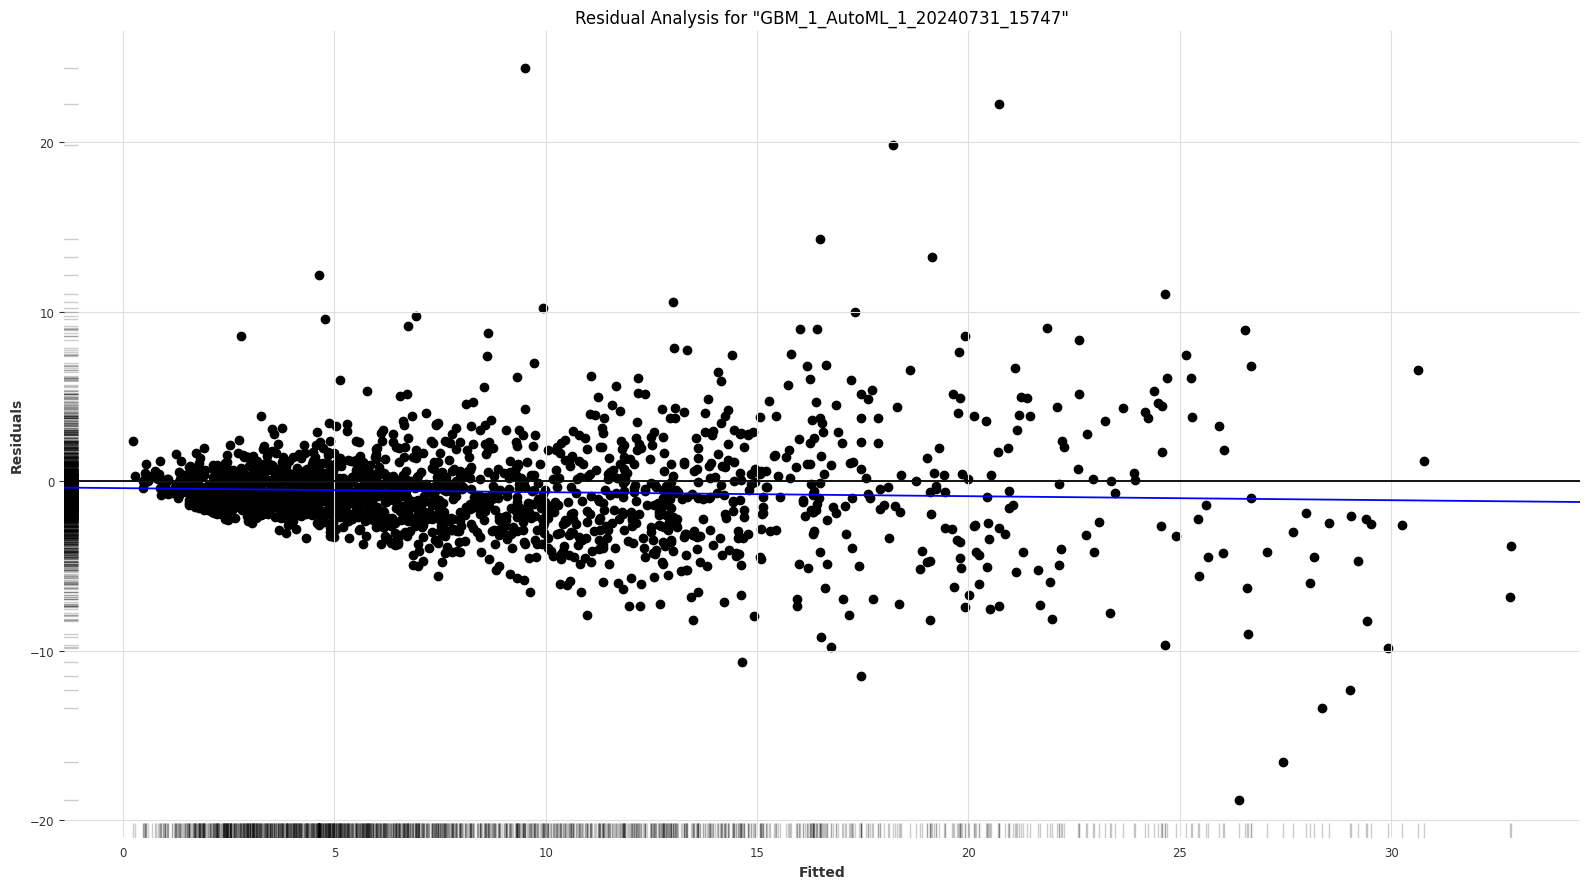

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

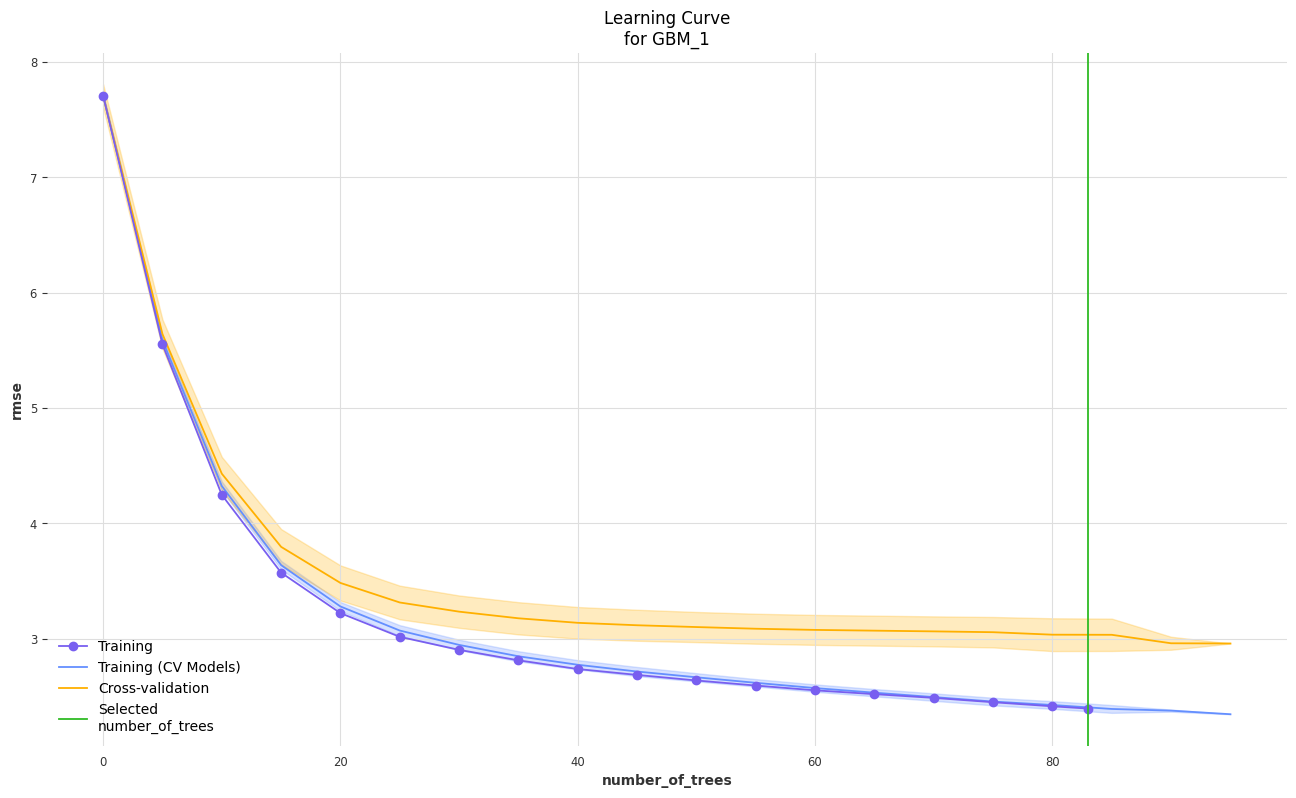

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

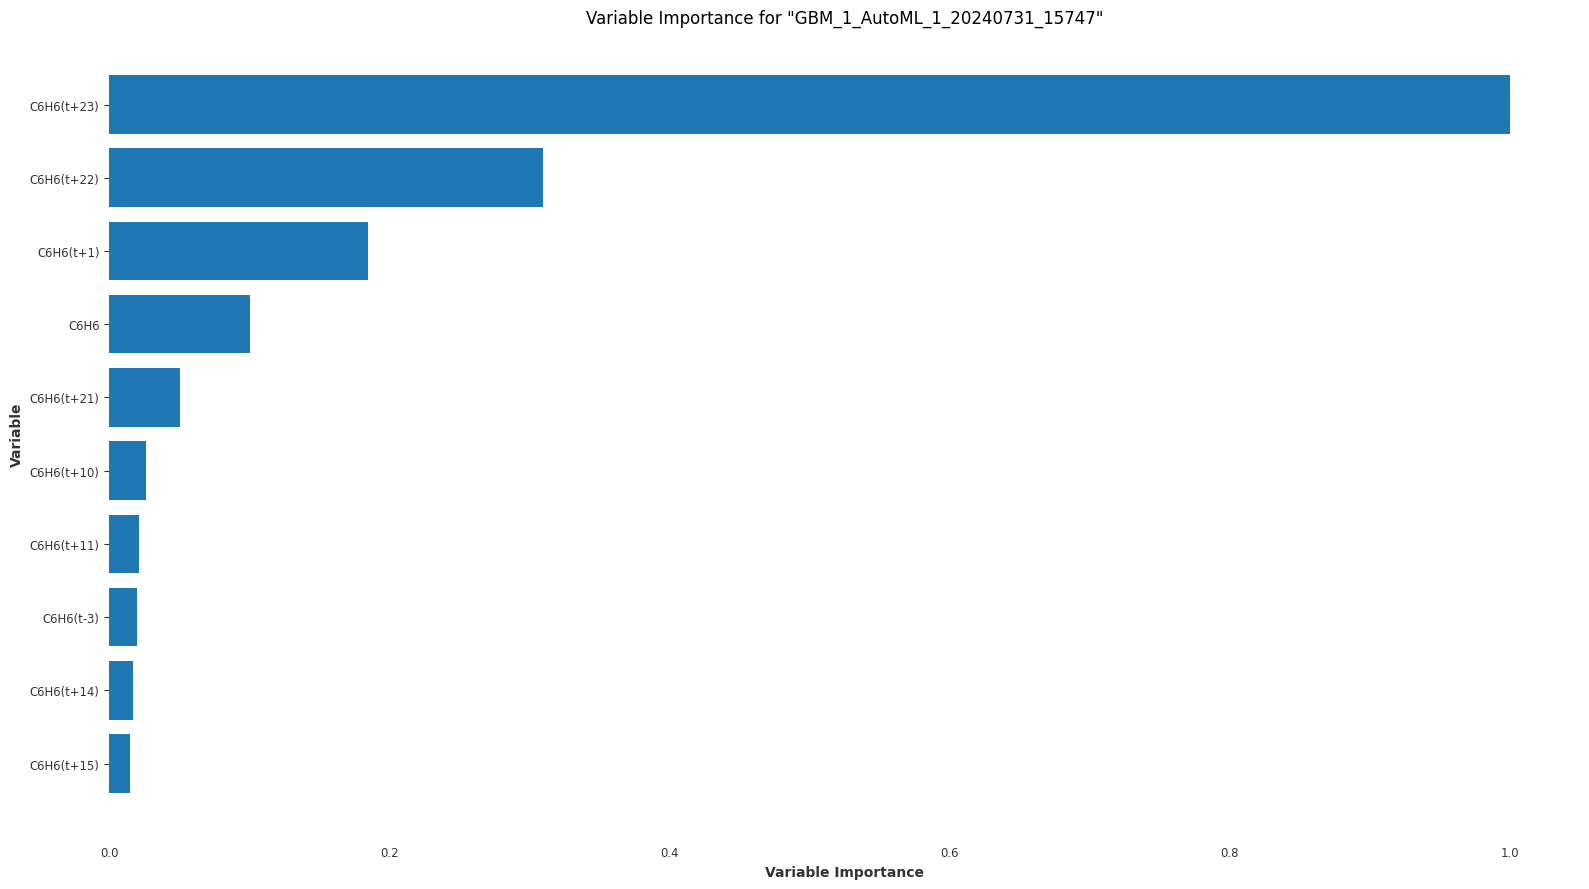

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

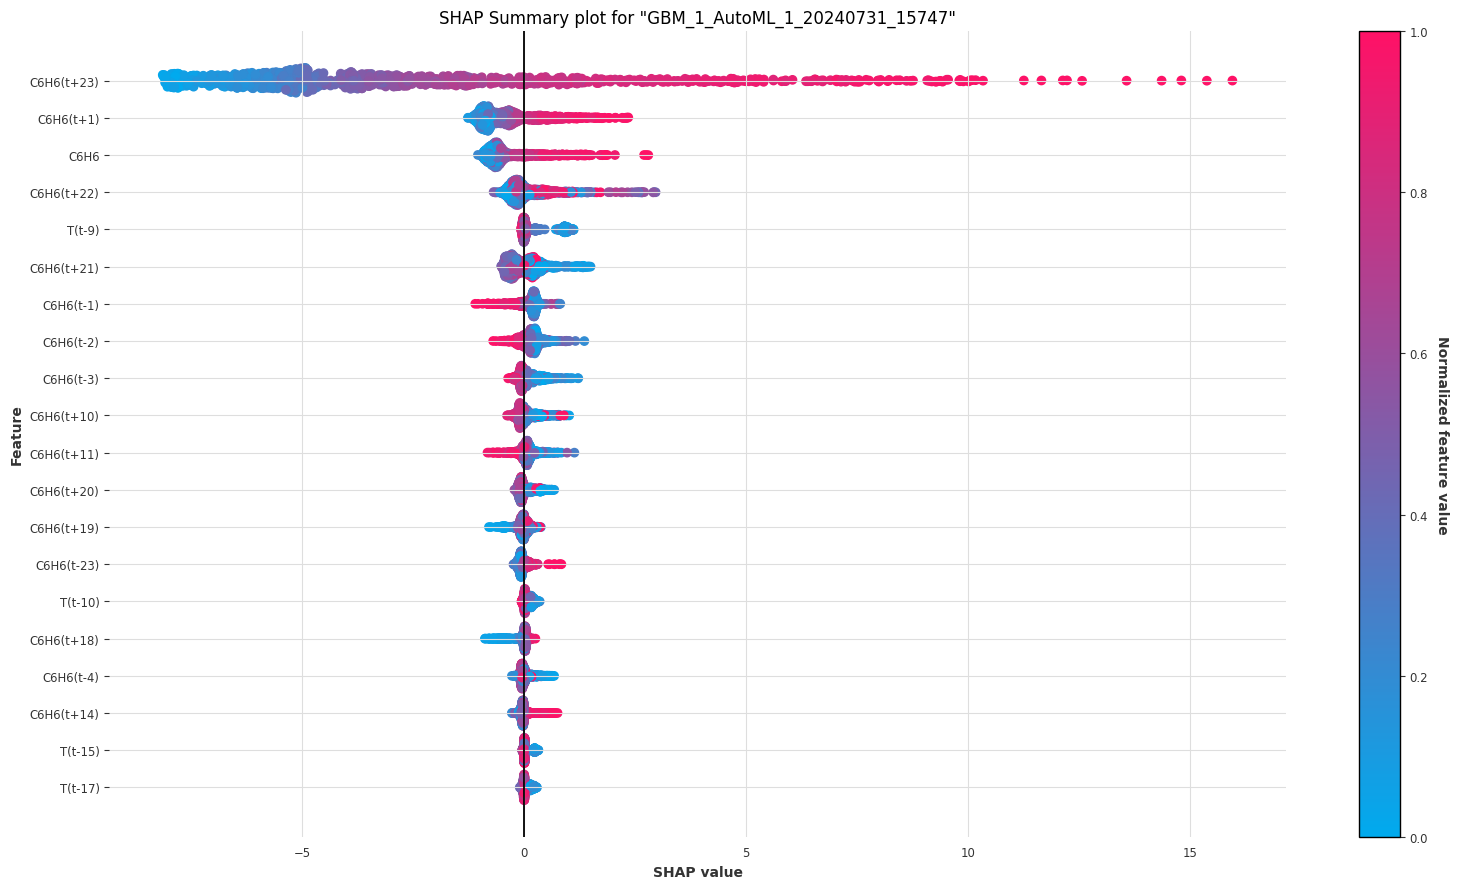

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

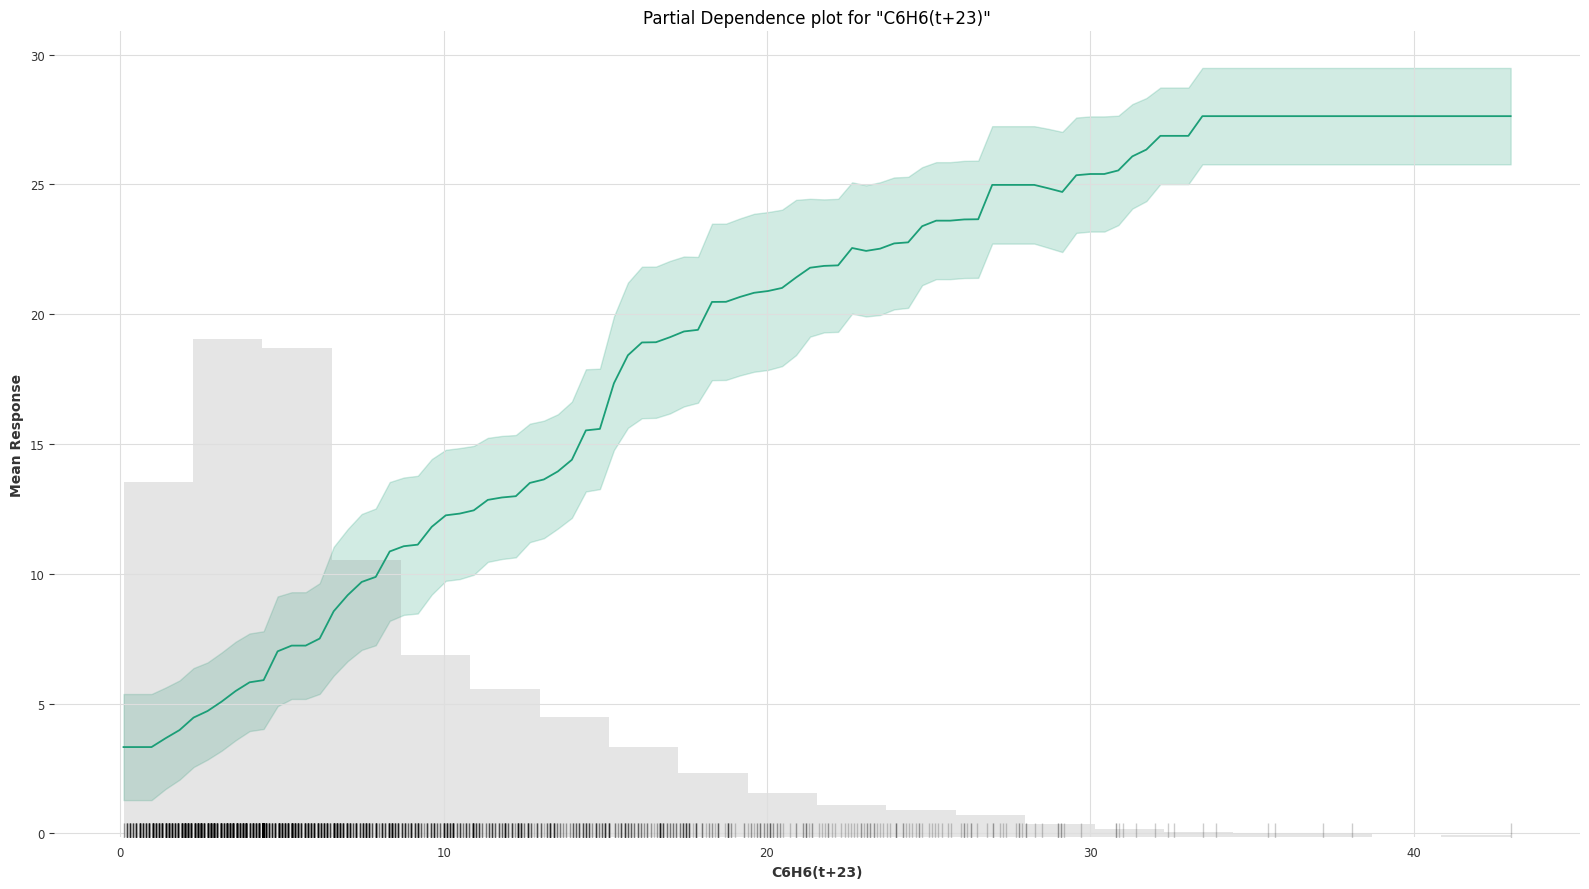

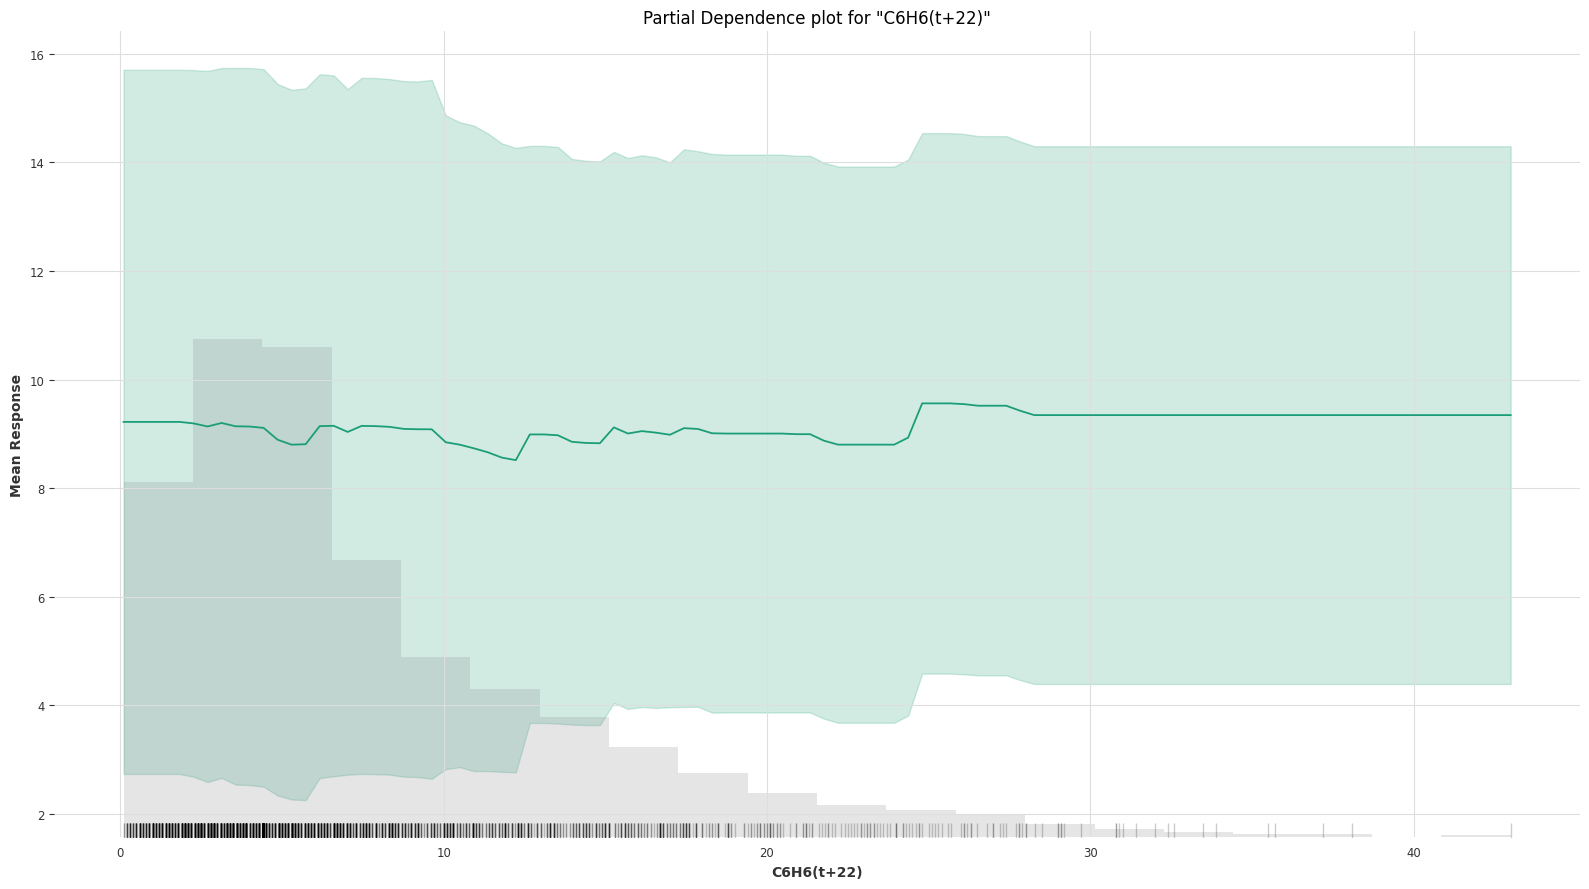

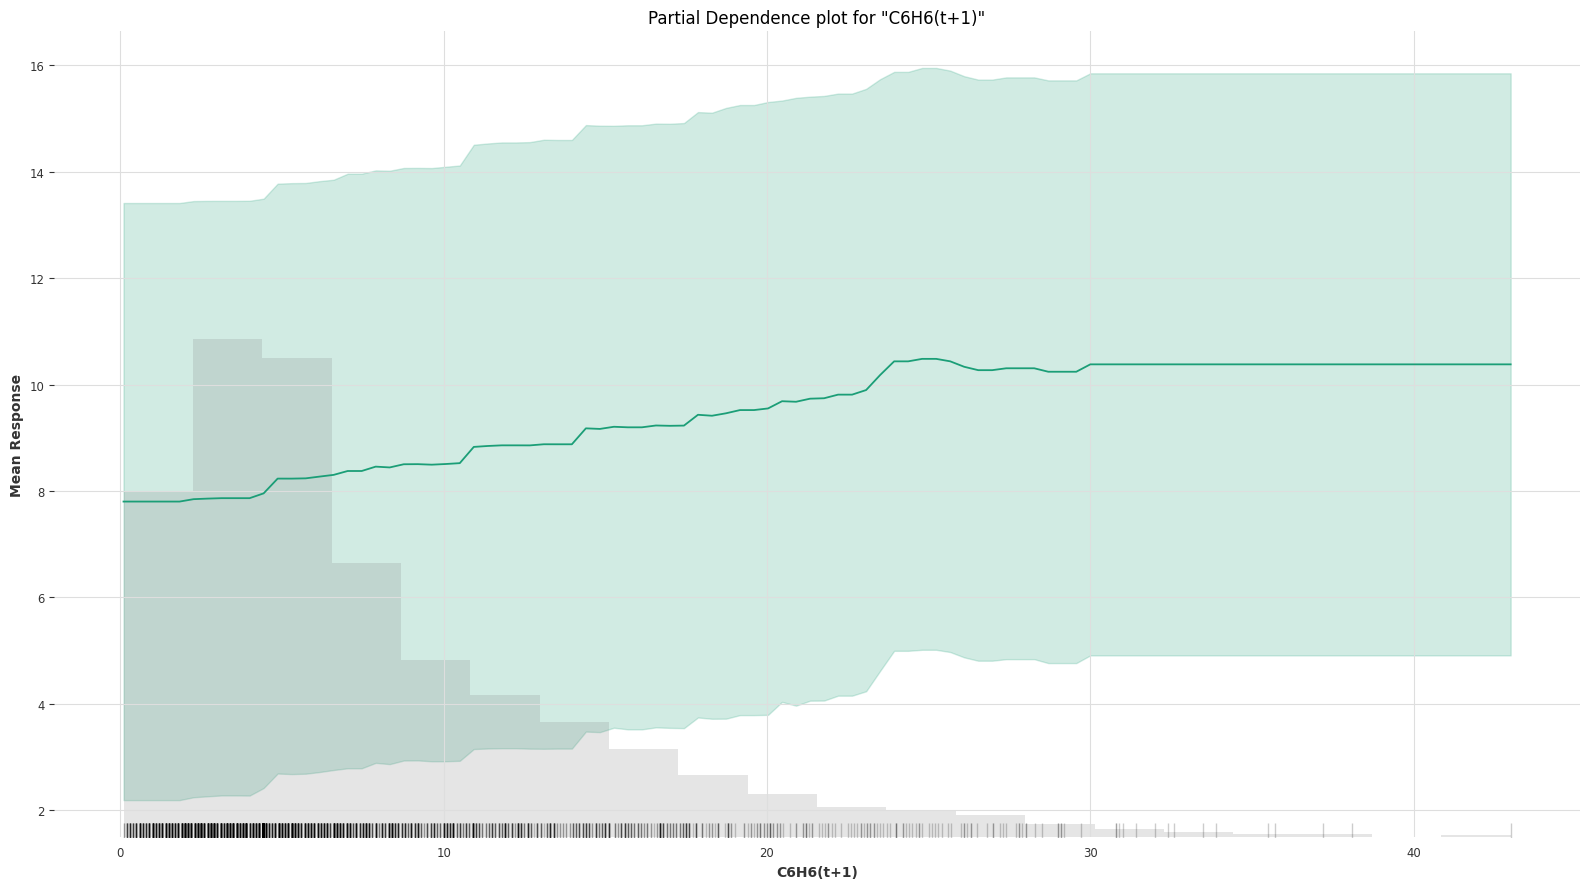

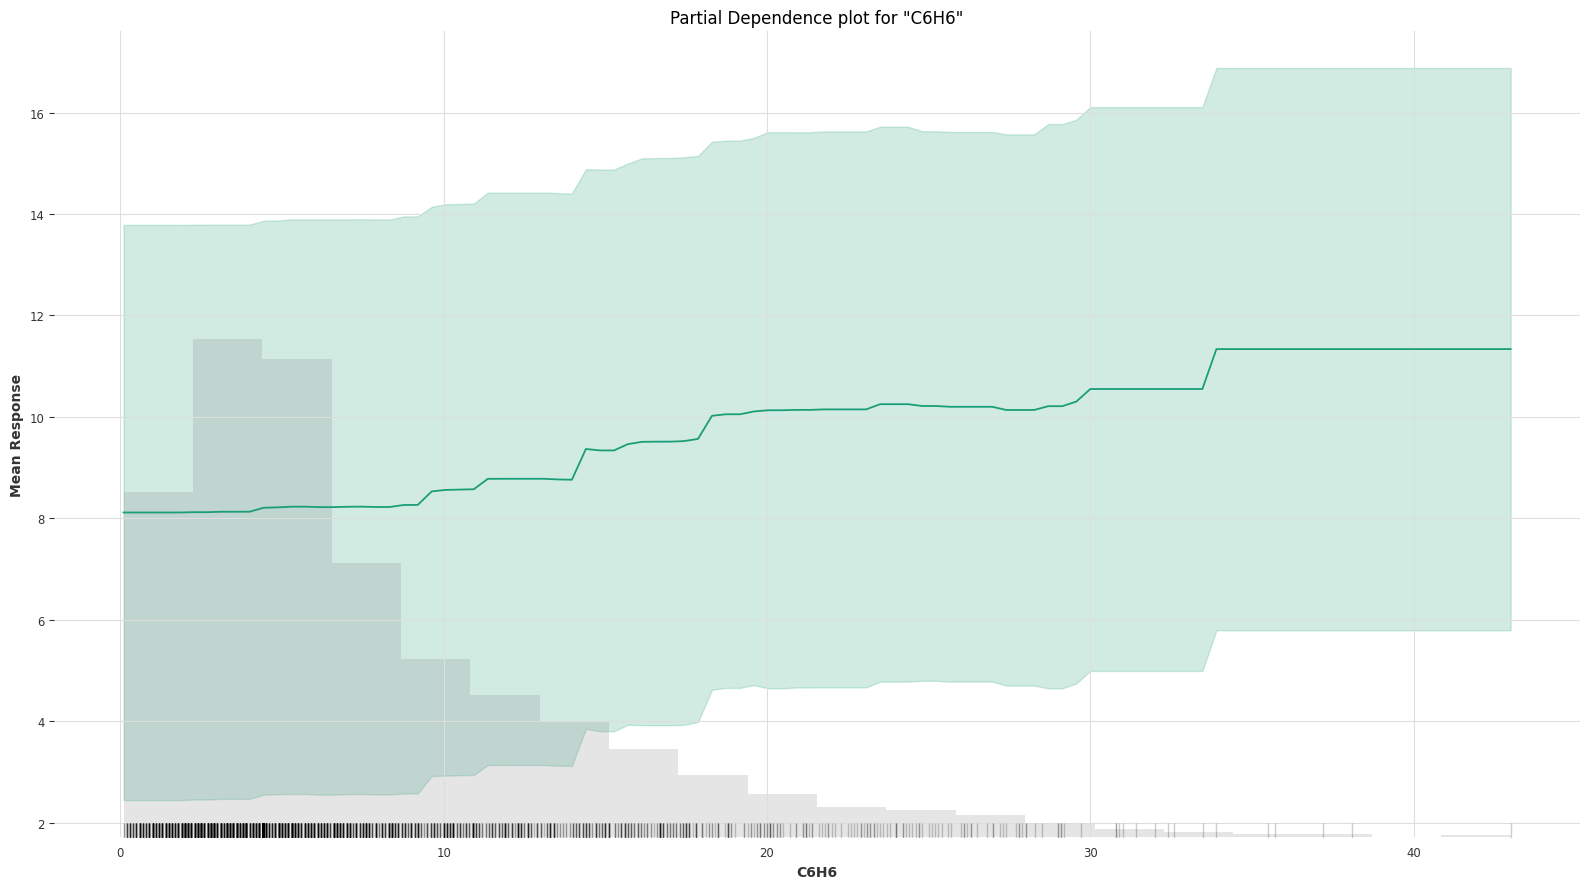

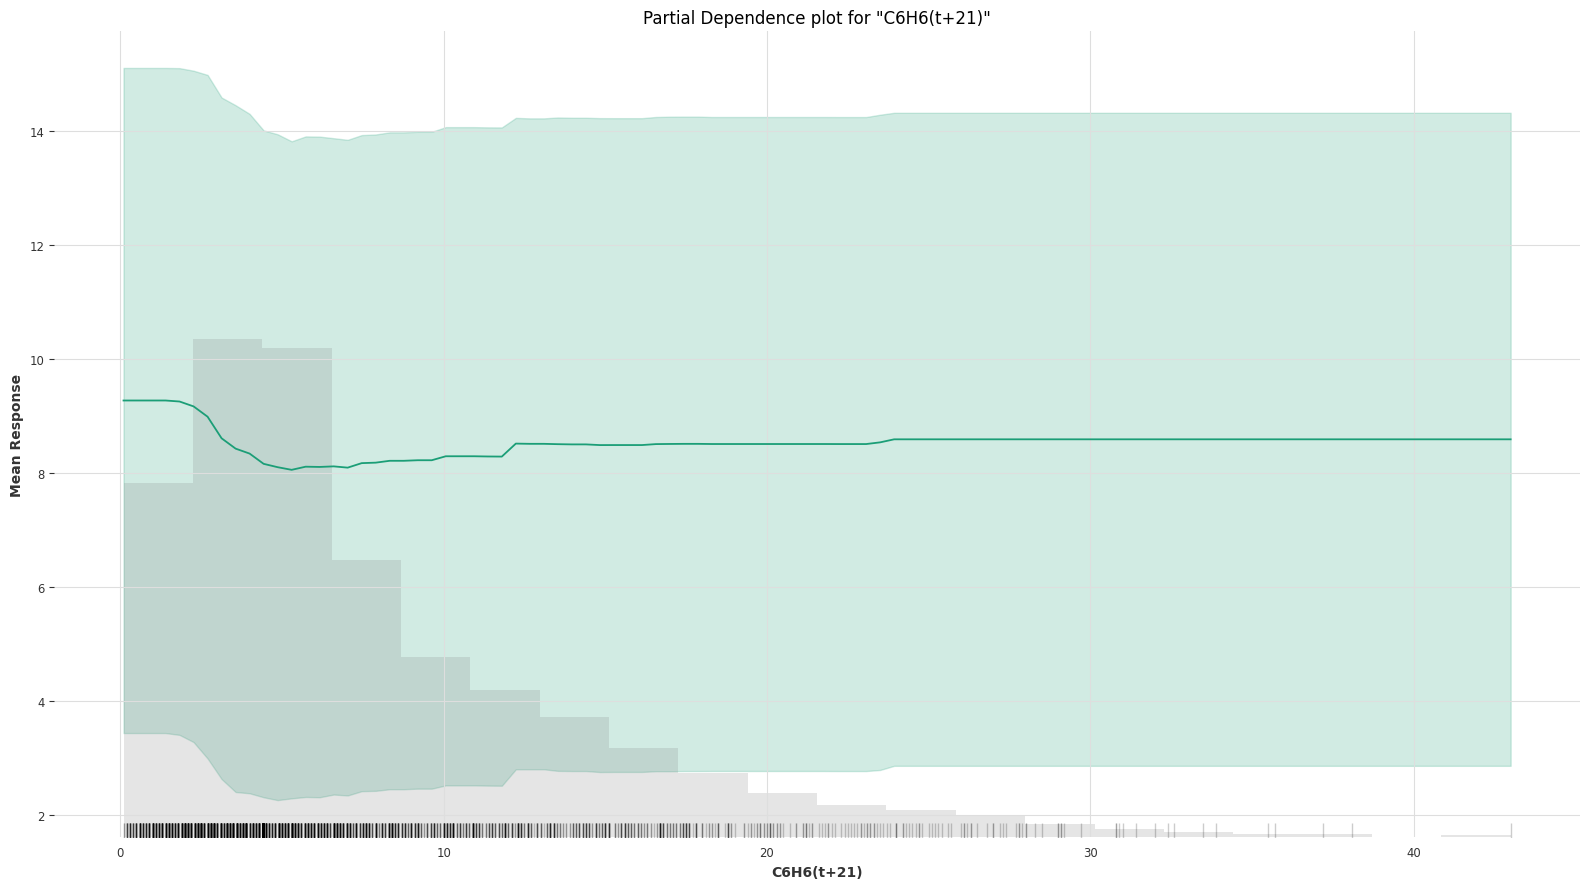

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

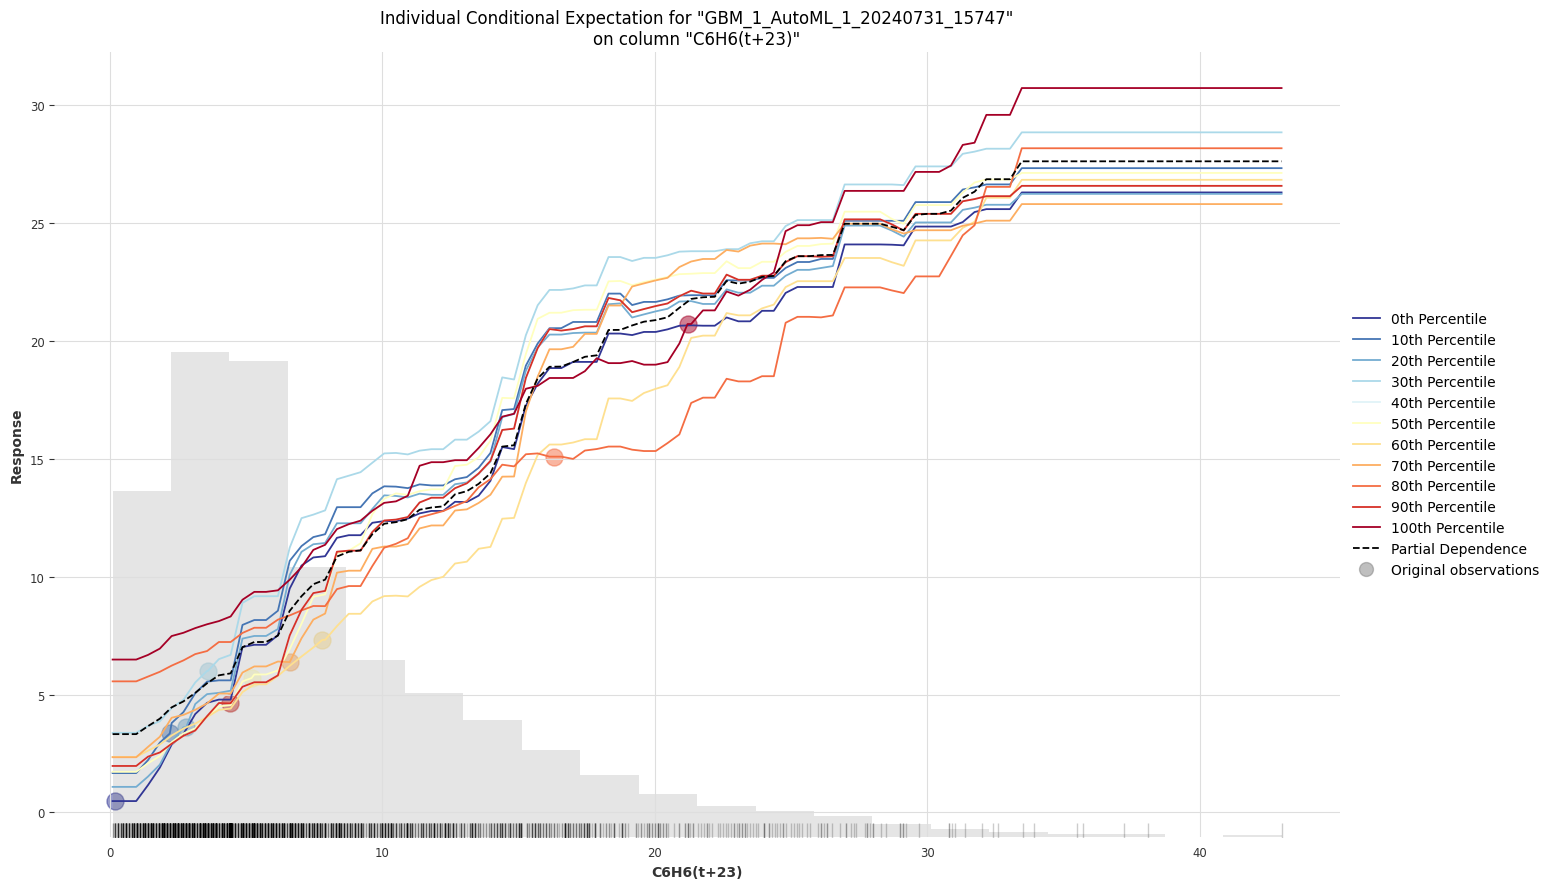

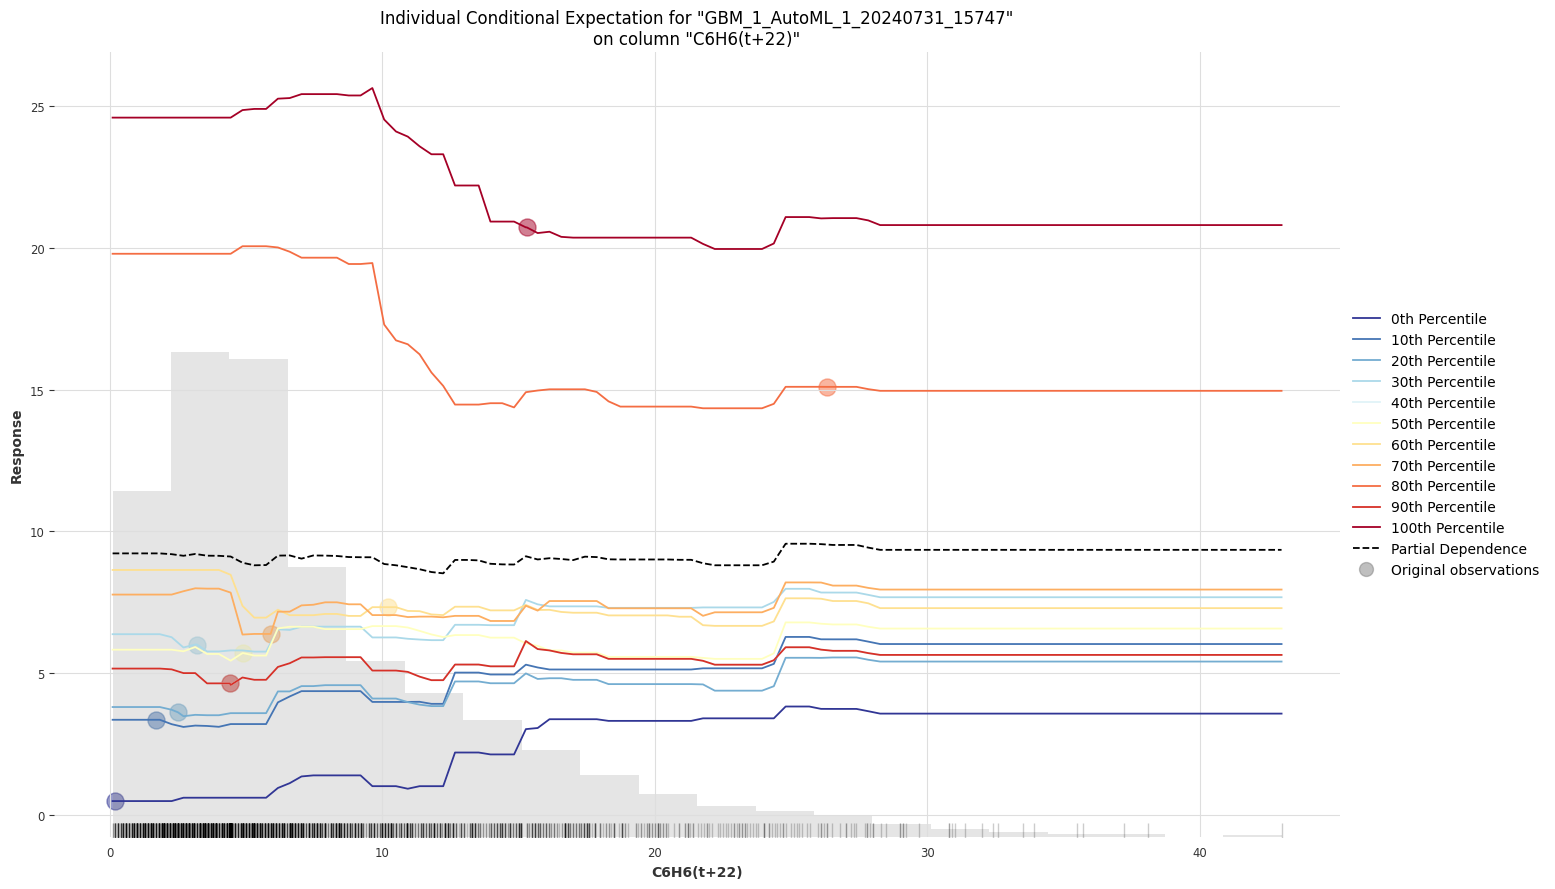

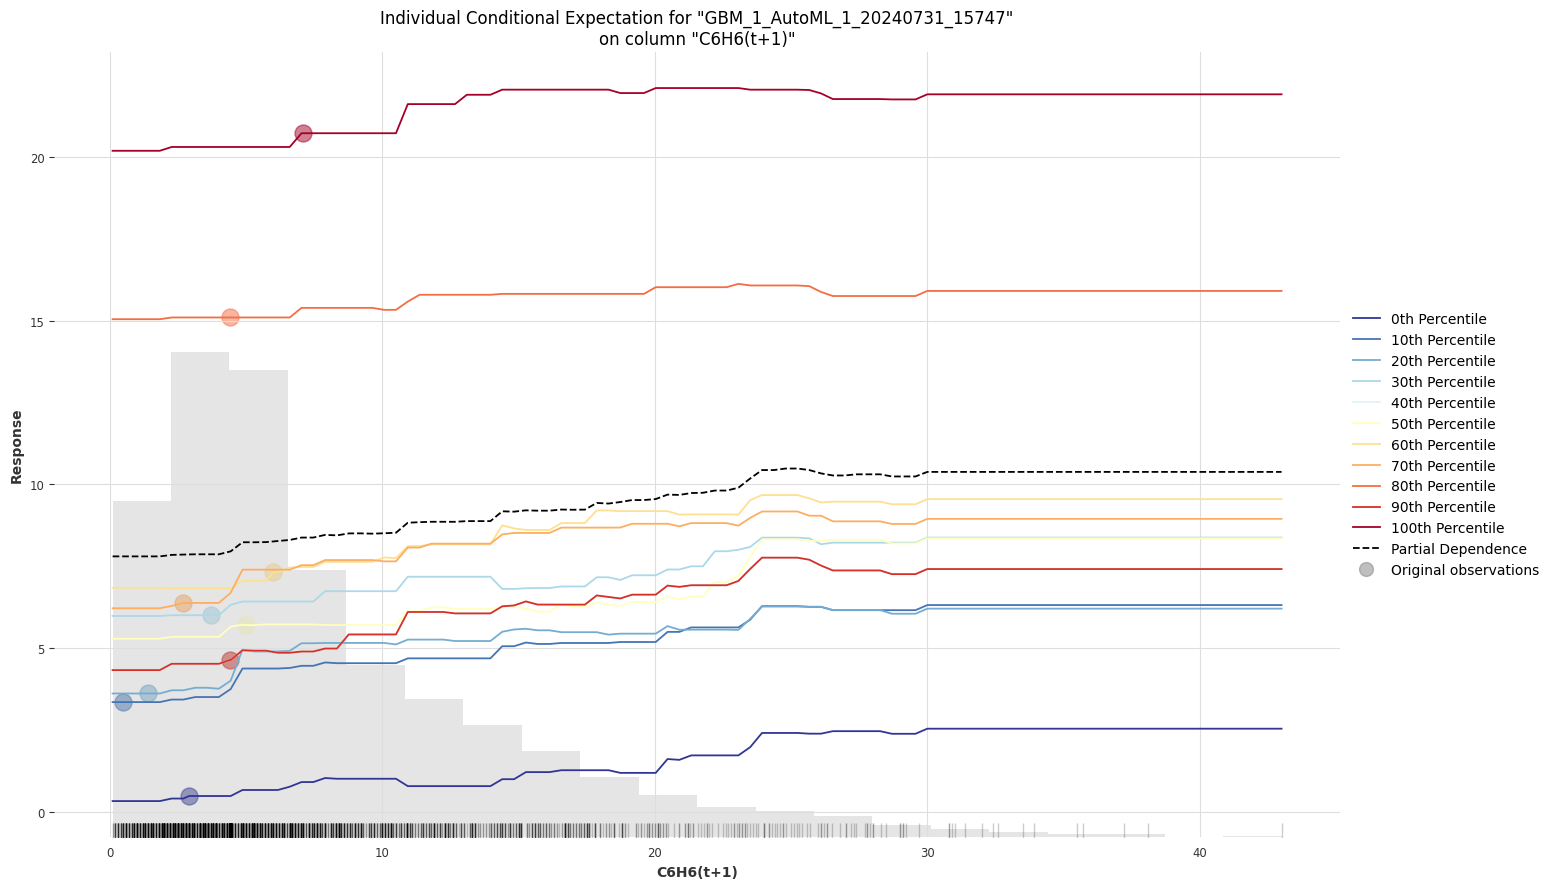

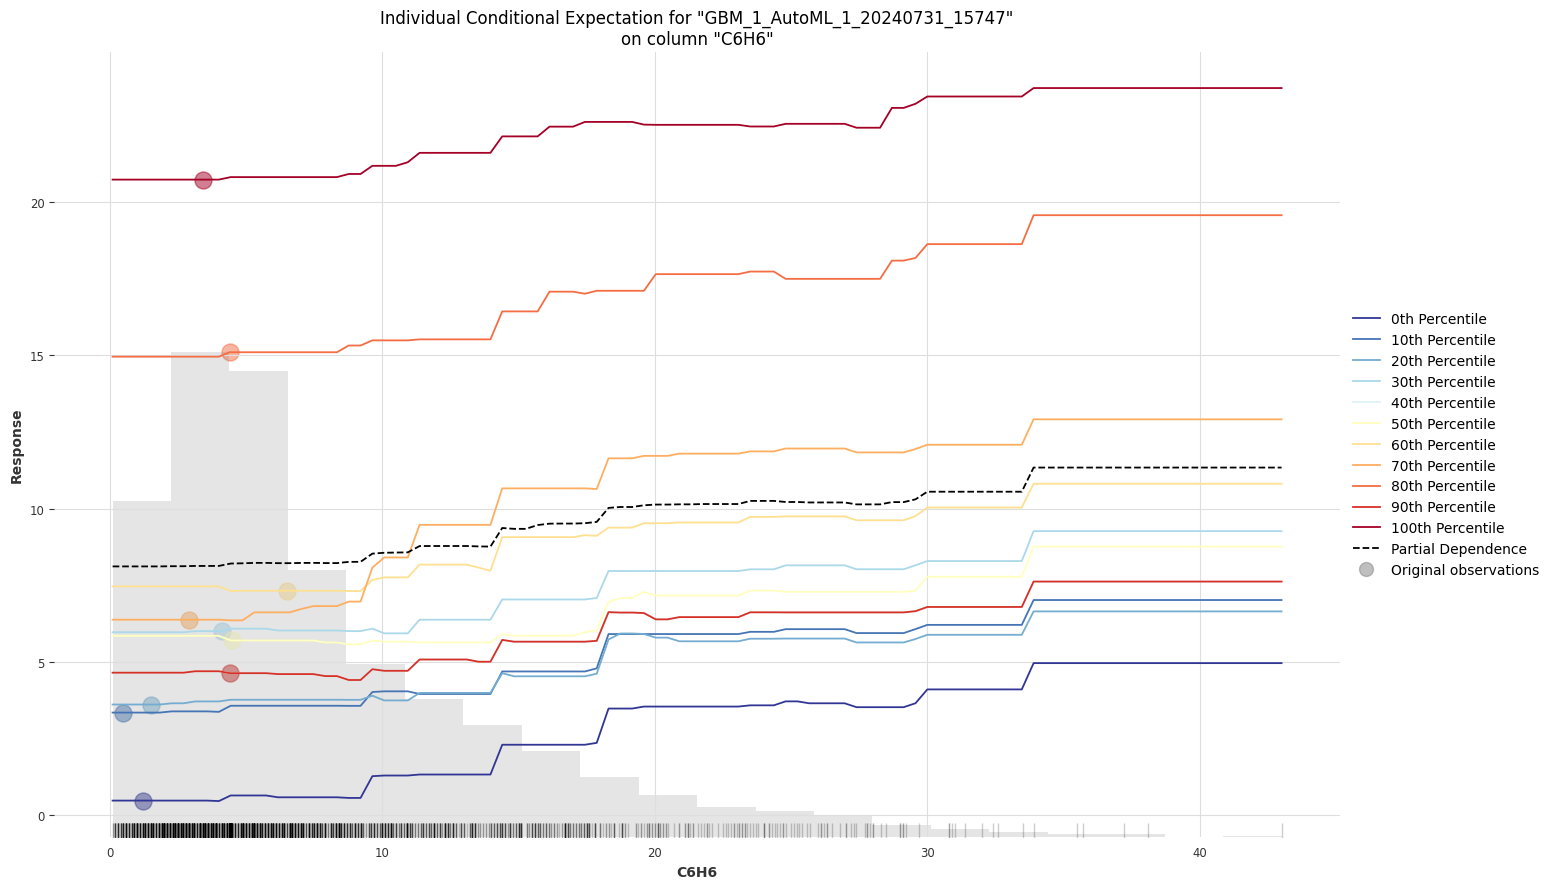

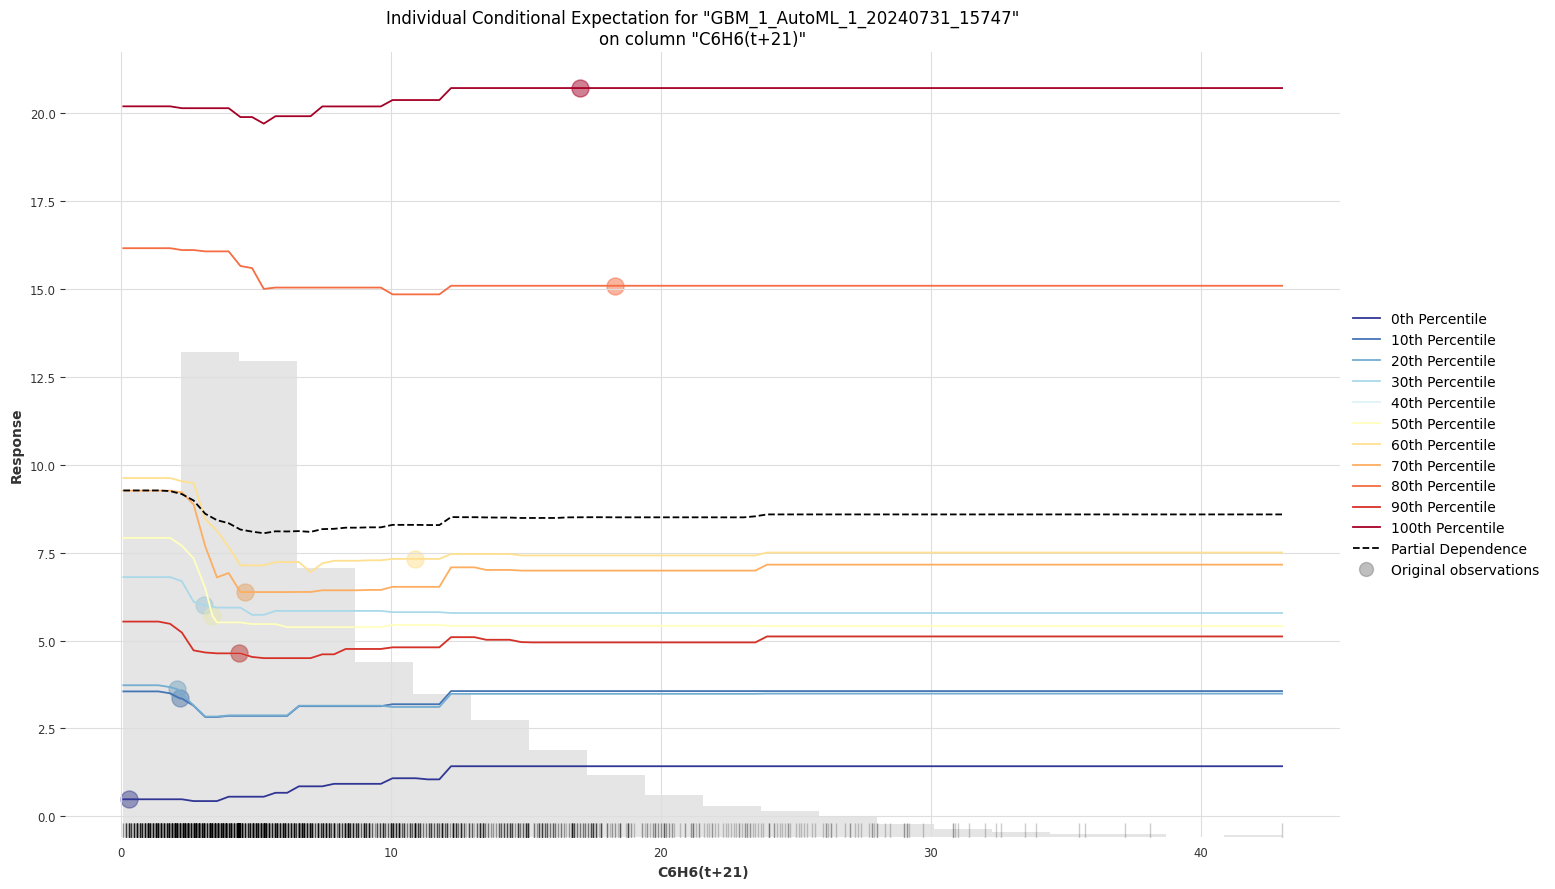

In [31]:
# Graficas para explicación el mejor modelo
exm = aml3.leader.explain(df_test)

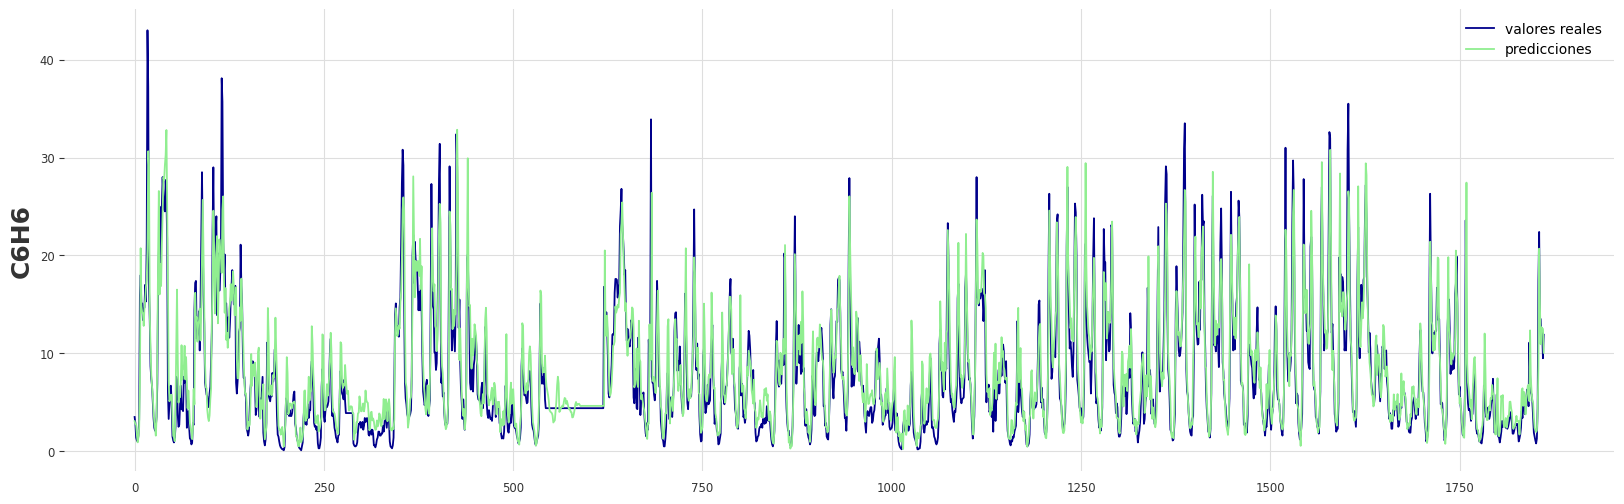

In [33]:
# Gráfico de las predicciones junto con los valores reales
plt.figure(figsize=(20, 6))
plt.plot(df_results['valores reales'], color='darkblue')
plt.plot(df_results['predicciones'], color='lightgreen')
plt.ylabel('C6H6',fontsize=18)
plt.legend(['valores reales','predicciones'])
plt.show()